In [84]:
import pandas as pd
import os
from pathlib import Path
import glob
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.feature_selection import SelectKBest, f_classif
import warnings
warnings.filterwarnings('ignore')
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


# Model

In [ ]:

import pandas as pd
df = pd.read_csv(r'.\lh.csv')

df = df.drop('Subject', axis=1)



## Preprocessing

In [86]:

def preprocess_data(df):
    
    target_candidates = [col for col in df.columns if 'epilep' in col.lower() or 'target' in col.lower() or 'label' in col.lower()]
    
    if not target_candidates:
        print("No target column found. Please specify the target column name.")
        
        return None, None, None
    
    target_col = target_candidates[0]
    print(f"Using '{target_col}' as target variable")
    
    
    X = df.drop(columns=[target_col])
    y = df[target_col]
    
    
    if y.dtype == 'object':
        le = LabelEncoder()
        y = le.fit_transform(y)
        print(f"Target classes: {le.classes_}")
    
   
    numeric_cols = X.select_dtypes(include=[np.number]).columns
    X = X[numeric_cols]
    
    print(f"Features shape: {X.shape}")
    print(f"Target distribution:")
    print(pd.Series(y).value_counts())
    
    return X, y, target_col

In [87]:
X, y, target_col = preprocess_data(df)

Using 'Epileptic_Status' as target variable
Target classes: ['Epileptic' 'Not Epileptic']
Features shape: (542, 593)
Target distribution:
0    442
1    100
Name: count, dtype: int64


In [88]:
def feature_engineering(X, y):
    """Perform feature engineering and selection"""
    
    X = X.fillna(X.median())
    
    # Remove constant features
    constant_features = X.columns[X.var() == 0]
    if len(constant_features) > 0:
        print(f"Removing {len(constant_features)} constant features")
        X = X.drop(columns=constant_features)
    
    
    selector = SelectKBest(score_func=f_classif, k=min(50, X.shape[1]))
    X_selected = selector.fit_transform(X, y)
    selected_features = X.columns[selector.get_support()]
    
    print(f"Selected {len(selected_features)} features out of {X.shape[1]}")
    
    return pd.DataFrame(X_selected, columns=selected_features), selected_features

# PCA


Explained variance ratio:
PC1: 0.1373 (13.73%)
PC2: 0.0796 (7.96%)
PC3: 0.0495 (4.95%)
PC4: 0.0374 (3.74%)
PC5: 0.0168 (1.68%)
PC6: 0.0156 (1.56%)
PC7: 0.0141 (1.41%)
PC8: 0.0135 (1.35%)
PC9: 0.0130 (1.30%)
PC10: 0.0125 (1.25%)

Cumulative explained variance:
PC1-PC1: 0.1373 (13.73%)
PC1-PC2: 0.2169 (21.69%)
PC1-PC3: 0.2664 (26.64%)
PC1-PC4: 0.3038 (30.38%)
PC1-PC5: 0.3206 (32.06%)
PC1-PC6: 0.3362 (33.62%)
PC1-PC7: 0.3502 (35.02%)
PC1-PC8: 0.3637 (36.37%)
PC1-PC9: 0.3767 (37.67%)
PC1-PC10: 0.3892 (38.92%)


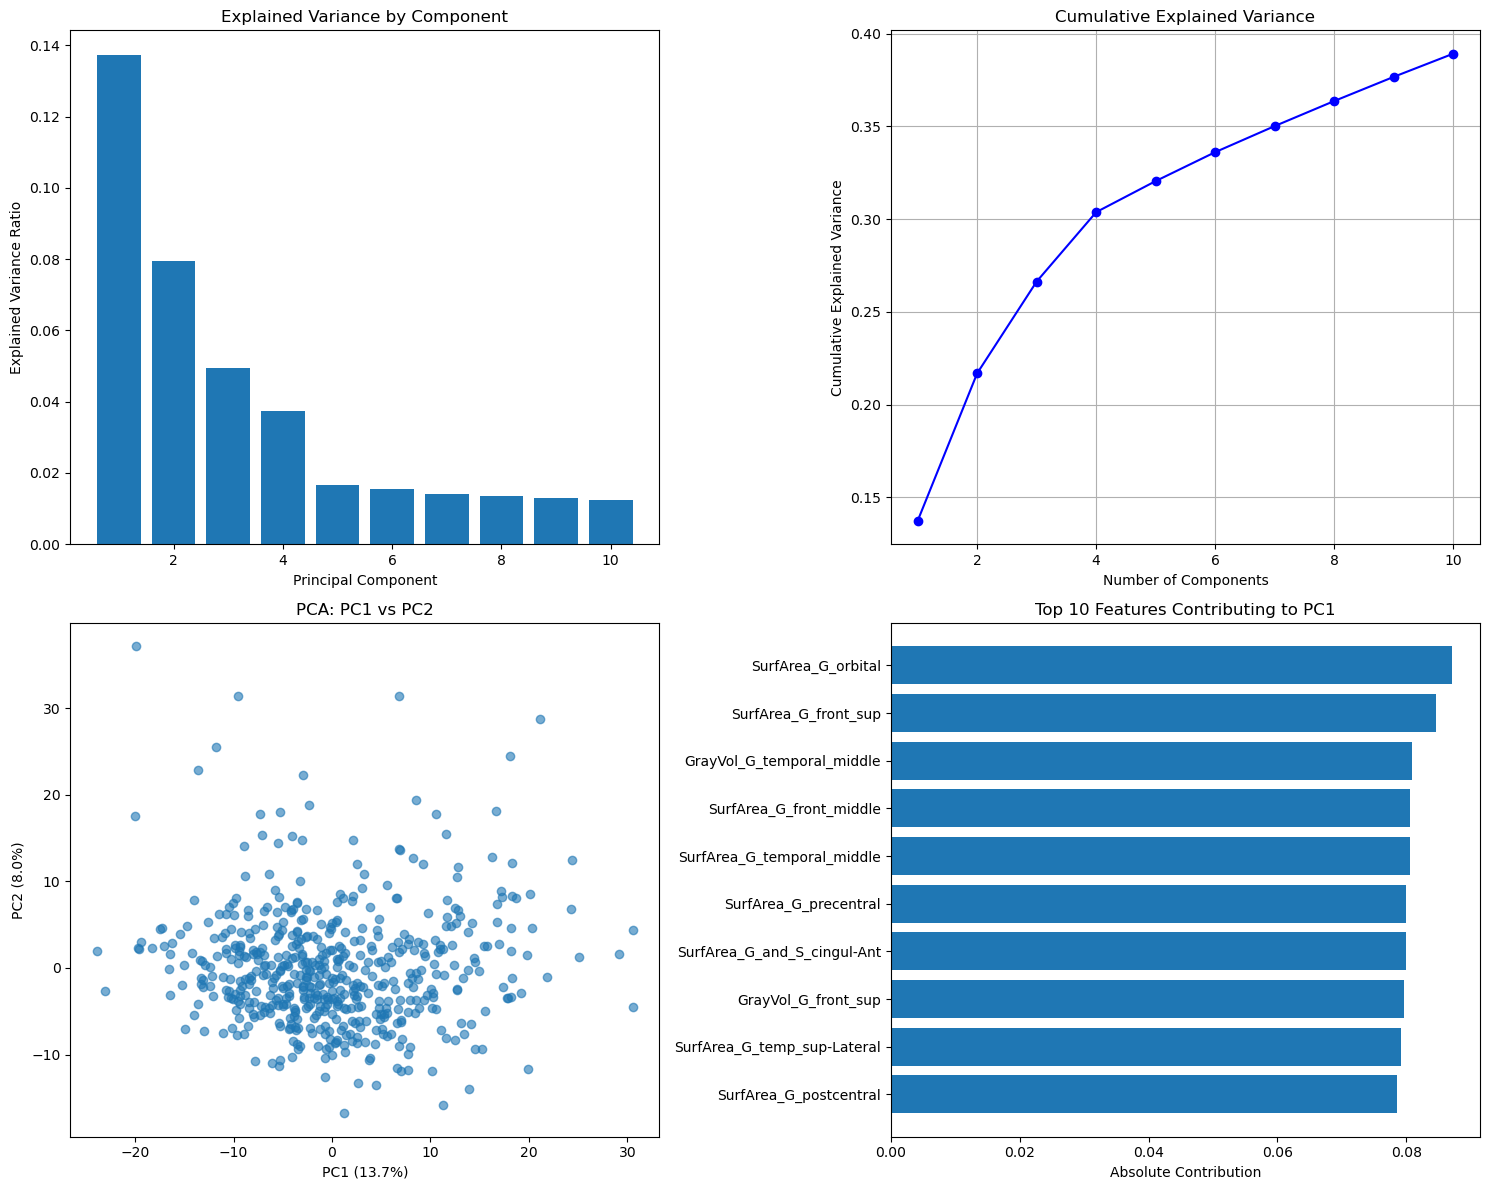

In [89]:


df = pd.read_csv('.\lh.csv')
df = df.drop('Subject', axis=1)

numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()


X = df[numerical_cols]
X = X.fillna(X.mean())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
n_components = 10  # Number of principal components to keep
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)


pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(n_components)])

print(f"\nExplained variance ratio:")
for i, ratio in enumerate(pca.explained_variance_ratio_):
    print(f"PC{i+1}: {ratio:.4f} ({ratio*100:.2f}%)")

print(f"\nCumulative explained variance:")
cumsum = np.cumsum(pca.explained_variance_ratio_)
for i, cum in enumerate(cumsum):
    print(f"PC1-PC{i+1}: {cum:.4f} ({cum*100:.2f}%)")


fig, axes = plt.subplots(2, 2, figsize=(15, 12))

axes[0, 0].bar(range(1, n_components+1), pca.explained_variance_ratio_)
axes[0, 0].set_xlabel('Principal Component')
axes[0, 0].set_ylabel('Explained Variance Ratio')
axes[0, 0].set_title('Explained Variance by Component')

axes[0, 1].plot(range(1, n_components+1), cumsum, 'bo-')
axes[0, 1].set_xlabel('Number of Components')
axes[0, 1].set_ylabel('Cumulative Explained Variance')
axes[0, 1].set_title('Cumulative Explained Variance')
axes[0, 1].grid(True)


axes[1, 0].scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.6)
axes[1, 0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
axes[1, 0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
axes[1, 0].set_title('PCA: PC1 vs PC2')


feature_contributions = abs(pca.components_[0])
top_features_idx = np.argsort(feature_contributions)[-10:]  # Top 10 features
top_features = [numerical_cols[i] for i in top_features_idx]
top_contributions = feature_contributions[top_features_idx]

axes[1, 1].barh(range(len(top_features)), top_contributions)
axes[1, 1].set_yticks(range(len(top_features)))
axes[1, 1].set_yticklabels(top_features)
axes[1, 1].set_xlabel('Absolute Contribution')
axes[1, 1].set_title('Top 10 Features Contributing to PC1')

plt.tight_layout()
plt.show()


## Training of the model

In [90]:
def train_models(X, y):
    """Train multiple models and compare performance"""
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
   
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    #list of the models used
    models = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
        'SVM': SVC(random_state=42, probability=True)
    }
    
    results = {}
    
    print("Training models...")
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        
        if name in ['Logistic Regression', 'SVM']:
            X_train_model = X_train_scaled
            X_test_model = X_test_scaled
        else:
            X_train_model = X_train
            X_test_model = X_test
        
        
        model.fit(X_train_model, y_train)

        y_pred = model.predict(X_test_model)
        y_pred_proba = model.predict_proba(X_test_model)[:, 1]
        
        
        cv_scores = cross_val_score(model, X_train_model, y_train, cv=5, scoring='accuracy')
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        
        results[name] = {
            'model': model,
            'cv_accuracy': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'test_accuracy': (y_pred == y_test).mean(),
            'roc_auc': roc_auc,
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba,
            'scaler': scaler if name in ['Logistic Regression', 'SVM'] else None
        }
        
        print(f"CV Accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
        print(f"Test Accuracy: {results[name]['test_accuracy']:.3f}")
        print(f"ROC AUC: {roc_auc:.3f}")
    
    return results, X_test, y_test

### Evaluation

In [91]:
def evaluate_models(results, X_test, y_test):
    """Evaluate and visualize model performance"""
    print("\n" + "="*50)
    print("MODEL COMPARISON")
    print("="*50)
    
    
    comparison_df = pd.DataFrame({
        'Model': list(results.keys()),
        'CV Accuracy': [results[model]['cv_accuracy'] for model in results],
        'Test Accuracy': [results[model]['test_accuracy'] for model in results],
        'ROC AUC': [results[model]['roc_auc'] for model in results]
    })
    
    print(comparison_df.round(3))
    
    
    best_model_name = comparison_df.loc[comparison_df['ROC AUC'].idxmax(), 'Model']
    best_model_results = results[best_model_name]
    
    print(f"\nBest model: {best_model_name}")
    print(f"Best ROC AUC: {best_model_results['roc_auc']:.3f}")
    
    
    print(f"\nDetailed evaluation for {best_model_name}:")
    print("\nClassification Report:")
    print(classification_report(y_test, best_model_results['y_pred']))
    
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, best_model_results['y_pred'])
    print(cm)
    
    return best_model_name, best_model_results, comparison_df

## Visualization

In [92]:
def plot_results(results, comparison_df):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    axes[0, 0].bar(comparison_df['Model'], comparison_df['ROC AUC'])
    axes[0, 0].set_title('Model Comparison - ROC AUC')
    axes[0, 0].set_ylabel('ROC AUC Score')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # ROC curves
    axes[0, 1].set_title('ROC Curves')
    for name, result in results.items():
        fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
        axes[0, 1].plot(fpr, tpr, label=f"{name} (AUC = {result['roc_auc']:.3f})")
    axes[0, 1].plot([0, 1], [0, 1], 'k--')
    axes[0, 1].set_xlabel('False Positive Rate')
    axes[0, 1].set_ylabel('True Positive Rate')
    axes[0, 1].legend()
    
    # Feature importance 
    rf_model = results['Random Forest']['model']
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False).head(10)
    
    axes[1, 0].barh(feature_importance['feature'], feature_importance['importance'])
    axes[1, 0].set_title('Top 10 Feature Importances (Random Forest)')
    axes[1, 0].set_xlabel('Importance')
    
    # Confusion matrix heatmap
    best_model_name = comparison_df.loc[comparison_df['ROC AUC'].idxmax(), 'Model']
    cm = confusion_matrix(y_test, results[best_model_name]['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1])
    axes[1, 1].set_title(f'Confusion Matrix - {best_model_name}')
    axes[1, 1].set_ylabel('True Label')
    axes[1, 1].set_xlabel('Predicted Label')
    
    plt.tight_layout()
    plt.show()


## Tuning

In [93]:
def tune_best_model(X, y, best_model_name, best_model_results):
    """Perform hyperparameter tuning for the best model"""
    print(f"\nTuning hyperparameters for {best_model_name}...")
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    if best_model_name == 'Random Forest':
        param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5, 10]
        }
        model = RandomForestClassifier(random_state=42)
        
    elif best_model_name == 'Gradient Boosting':
        param_grid = {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7]
        }
        model = GradientBoostingClassifier(random_state=42)
        
    elif best_model_name == 'Logistic Regression':
        param_grid = {
            'C': [0.1, 1, 10],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear']
        }
        model = LogisticRegression(random_state=42, max_iter=1000)
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
    elif best_model_name == 'SVM':
        param_grid = {
            'C': [0.1, 1, 10],
            'kernel': ['rbf', 'linear'],
            'gamma': ['scale', 'auto']
        }
        model = SVC(random_state=42, probability=True)
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
    
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best CV score: {grid_search.best_score_:.3f}")
    
    
    tuned_model = grid_search.best_estimator_
    y_pred = tuned_model.predict(X_test)
    y_pred_proba = tuned_model.predict_proba(X_test)[:, 1]
    
    print(f"Tuned model test accuracy: {(y_pred == y_test).mean():.3f}")
    print(f"Tuned model ROC AUC: {roc_auc_score(y_test, y_pred_proba):.3f}")
    
    return tuned_model


Selected 50 features out of 593
Training models...

Training Random Forest...
CV Accuracy: 0.850 (+/- 0.049)
Test Accuracy: 0.844
ROC AUC: 0.842

Training Gradient Boosting...
CV Accuracy: 0.831 (+/- 0.019)
Test Accuracy: 0.835
ROC AUC: 0.842

Training Logistic Regression...
CV Accuracy: 0.838 (+/- 0.079)
Test Accuracy: 0.817
ROC AUC: 0.848

Training SVM...
CV Accuracy: 0.857 (+/- 0.038)
Test Accuracy: 0.853
ROC AUC: 0.856

MODEL COMPARISON
                 Model  CV Accuracy  Test Accuracy  ROC AUC
0        Random Forest        0.850          0.844    0.842
1    Gradient Boosting        0.831          0.835    0.842
2  Logistic Regression        0.838          0.817    0.848
3                  SVM        0.857          0.853    0.856

Best model: SVM
Best ROC AUC: 0.856

Detailed evaluation for SVM:

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91        89
           1       0.64      0.45      0.53        20



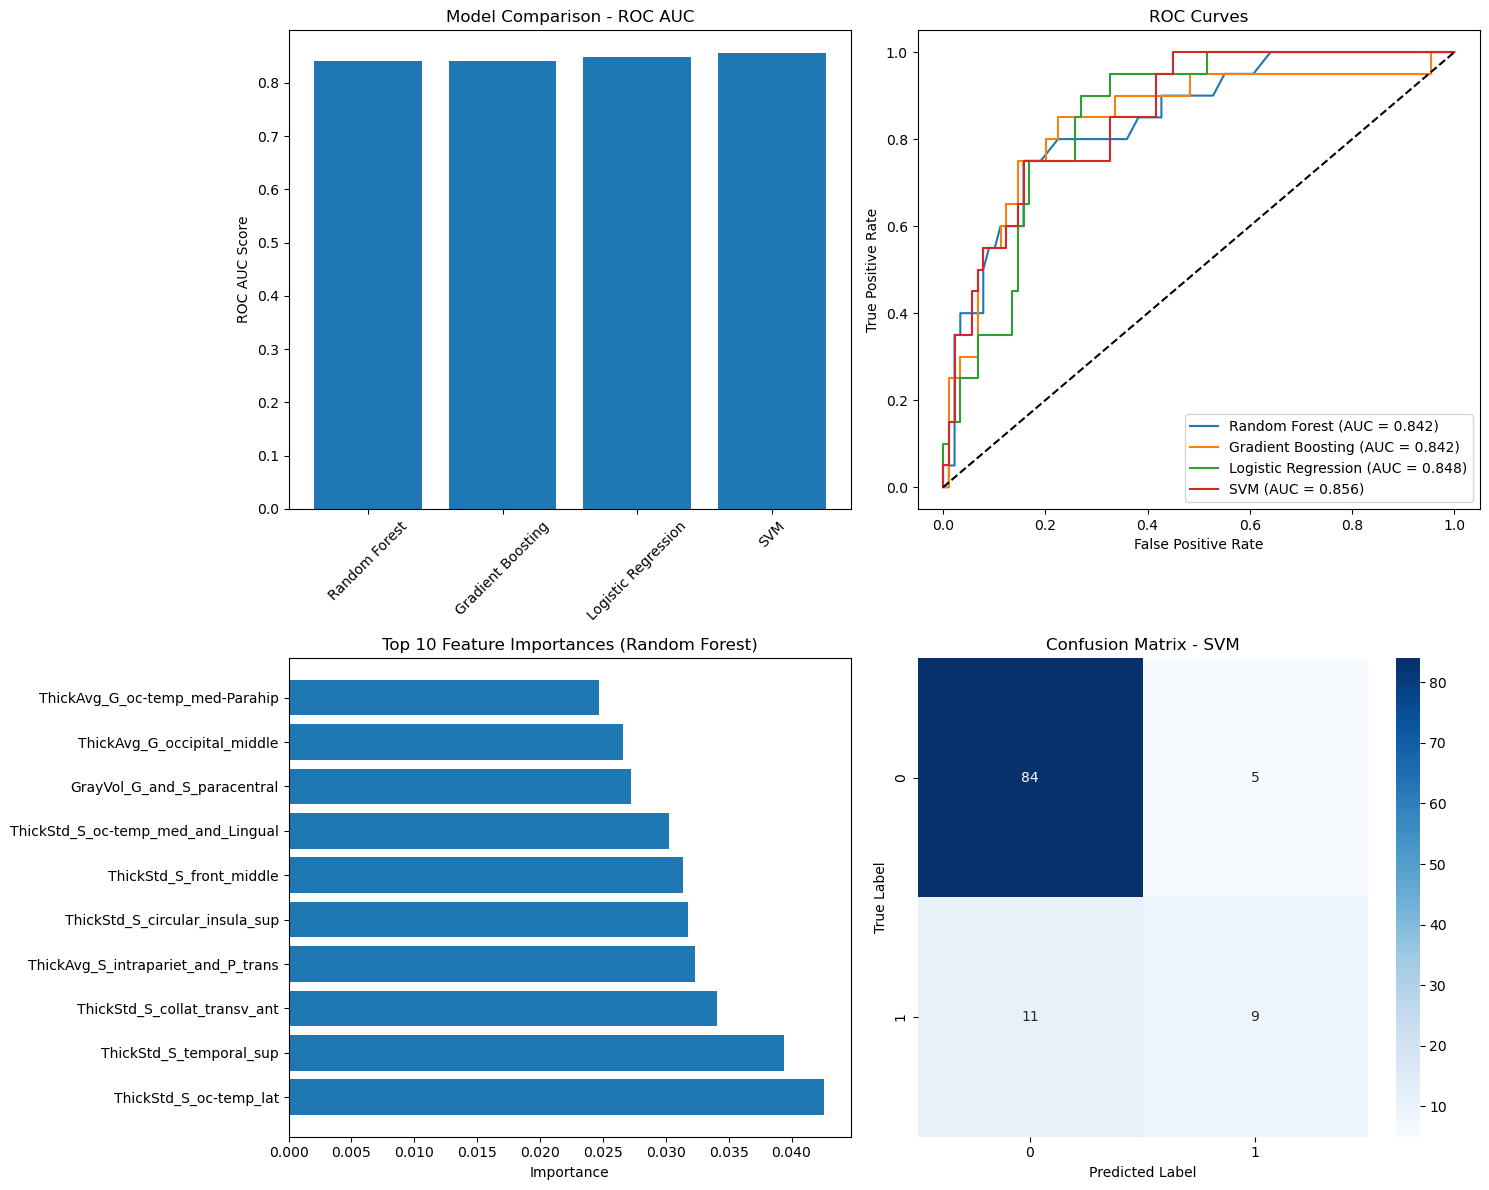


Tuning hyperparameters for SVM...
Best parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Best CV score: 0.800
Tuned model test accuracy: 0.826
Tuned model ROC AUC: 0.860
Best performing model: SVM


In [94]:
X, selected_features = feature_engineering(X, y)
            
           
results, X_test, y_test = train_models(X, y)
            
           
best_model_name, best_model_results, comparison_df = evaluate_models(results, X_test, y_test)
             
plot_results(results, comparison_df)
            
tuned_model = tune_best_model(X, y, best_model_name, best_model_results)
            

print(f"Best performing model: {best_model_name}")


In [95]:
def transform_resection_dataframe(df):
       
    df_transformed = df.copy()

    region_names = df_transformed.iloc[:, -1].copy() 
    data_columns = df_transformed.iloc[:, :-1]  
    data_columns = data_columns.replace('NaN', np.nan)
    data_columns = data_columns.astype(float)
    data_columns = data_columns.fillna(0)
    
    transformed_data = pd.DataFrame(0,index=data_columns.index,columns=data_columns.columns)
    
    for col in data_columns.columns:
        column_values = data_columns[col]
        
        max_value = column_values.max()
        max_indices = column_values == max_value
        transformed_data.loc[max_indices, col] = 1
      
        high_value_indices = column_values > 1
        transformed_data.loc[high_value_indices, col] = 1
    
  
    transformed_data['region_names'] = region_names
    
    return transformed_data



def transform_total():
   
    df = pd.read_csv(r'.\Subject\table_resected.csv', index_col=0)
    df_transformed = transform_resection_dataframe(df)
    
    return df_transformed



In [96]:
df_transformed = transform_total()
df_transformed.to_csv('resection.csv')

In [97]:

def update_lh_with_regions(resection_file='resection.csv', lh_file='lh.csv', output_file='lh_updated.csv'):

    
    df_resection = pd.read_csv(resection_file)
    

    patient_columns = [col for col in df_resection.columns 
                      if col != '' and col != 'region_names' and str(col).isdigit()]
    
    region_mapping = {}
    patients_with_multiple_regions = []
    
    for patient_id in patient_columns:
        
        affected_regions = []
        for region_idx, row in df_resection.iterrows():
            if row[patient_id] == 1:
                affected_regions.append(region_idx + 1) 
        
        
        if len(affected_regions) == 0:
            final_region = 0  # No epilepsy
        else:
            final_region = max(affected_regions)  
            
            
            if len(affected_regions) > 1:
                patients_with_multiple_regions.append({
                    'patient': patient_id,
                    'all_regions': affected_regions,
                    'max_selected': final_region,
                    'count': len(affected_regions)
                })
        
        region_mapping[int(patient_id)] = final_region
    
    
    
    
   
    df_lh = pd.read_csv(lh_file)
    
    
    
    
    def get_region_number(subject_id):
        
        return region_mapping.get(subject_id, 0)
    
    df_lh['Epileptic_Status'] = df_lh['Subject'].apply(get_region_number)
    
    

    matched_patients = len(df_lh[df_lh['Epileptic_Status'] > 0])
    unmatched_patients = len(df_lh[df_lh['Epileptic_Status'] == 0])
    
    df_lh.to_csv(output_file, index=False)
    return df_lh
 
    
   

In [98]:
df_updated = update_lh_with_regions('resection.csv', r'.\lh.csv', 'lh_updated.csv')

Using 'Epileptic_Status' as target variable
Selected 50 features out of 593
Training models...

Training Random Forest...
CV Balanced Accuracy: 0.051 (+/- 0.038)
Test Accuracy: 0.339
Balanced Test Accuracy: 0.061

Training Gradient Boosting...
CV Balanced Accuracy: 0.046 (+/- 0.033)
Test Accuracy: 0.211
Balanced Test Accuracy: 0.044

Training Logistic Regression...
CV Balanced Accuracy: 0.043 (+/- 0.015)
Test Accuracy: 0.202
Balanced Test Accuracy: 0.039

Training SVM...
CV Balanced Accuracy: 0.036 (+/- 0.006)
Test Accuracy: 0.165
Balanced Test Accuracy: 0.033
                 Model  CV Balanced Accuracy  Test Accuracy  \
0        Random Forest                 0.051          0.339   
1    Gradient Boosting                 0.046          0.211   
2  Logistic Regression                 0.043          0.202   
3                  SVM                 0.036          0.165   

   Balanced Test Accuracy  
0                   0.061  
1                   0.044  
2                   0.039  
3    

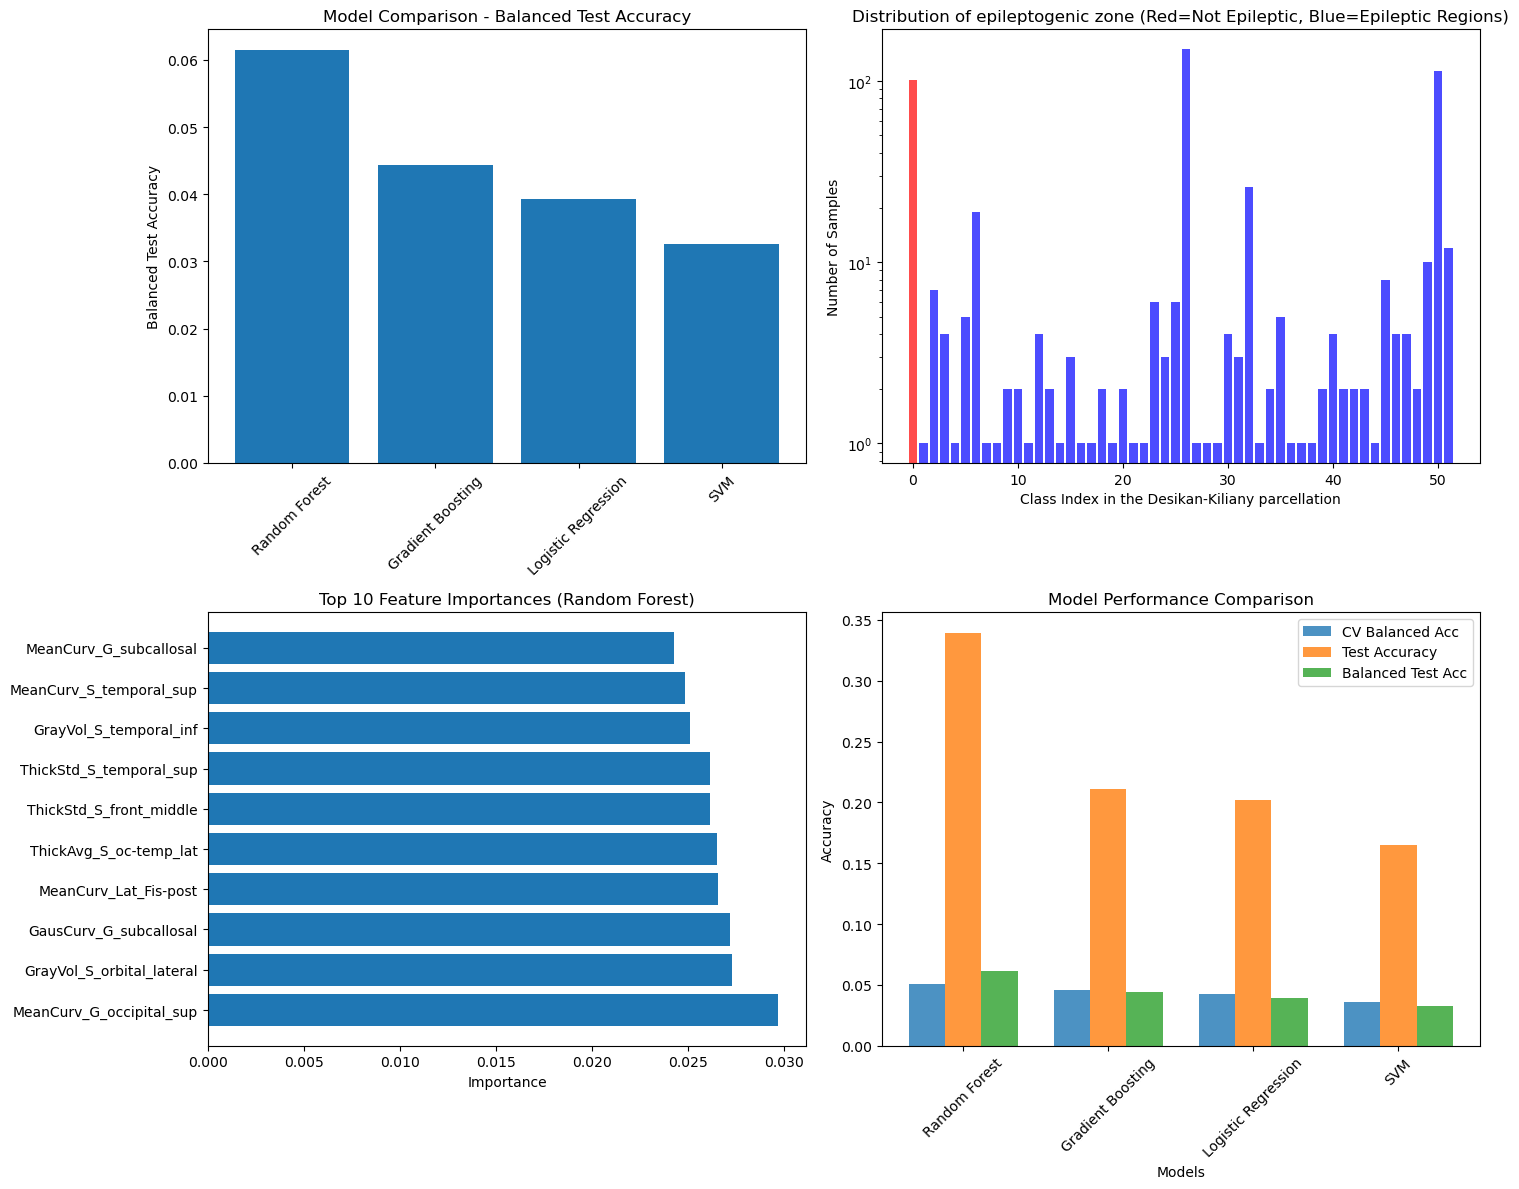


Tuning hyperparameters for Random Forest...
Best parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Best CV score: 0.063
Tuned model test accuracy: 0.312
Tuned model balanced accuracy: 0.058
Best performing model: Random Forest


In [106]:

df = pd.read_csv(r'.\lh_updated.csv')

df = df.drop('Subject', axis=1)


def preprocess_data(df):
    
    
    target_candidates = [col for col in df.columns if 'epilep' in col.lower() or 'target' in col.lower() or 'label' in col.lower()]
    
    if not target_candidates:
        
        print("No obvious target column found. Please specify the target column name.")
        print("Available columns:", df.columns.tolist())
        return None, None, None
    
    target_col = target_candidates[0]
    print(f"Using '{target_col}' as target variable")
    
    
    X = df.drop(columns=[target_col])
    y = df[target_col]
    
    
    if y.dtype == 'object':
        le = LabelEncoder()
        y = le.fit_transform(y)
        print(f"Target classes: {le.classes_}")
    
    
    numeric_cols = X.select_dtypes(include=[np.number]).columns
    X = X[numeric_cols]
    

    
    return X, y, target_col

X, y, target_col = preprocess_data(df)

def feature_engineering(X, y):
    
    
    X = X.fillna(X.median())
    
    # Remove constant features
    constant_features = X.columns[X.var() == 0]
    if len(constant_features) > 0:
        print(f"Removing {len(constant_features)} constant features")
        X = X.drop(columns=constant_features)
    
    
    selector = SelectKBest(score_func=f_classif, k=min(50, X.shape[1]))
    X_selected = selector.fit_transform(X, y)
    selected_features = X.columns[selector.get_support()]
    
    print(f"Selected {len(selected_features)} features out of {X.shape[1]}")
    
    return pd.DataFrame(X_selected, columns=selected_features), selected_features

def train_models(X, y):
    
    
    class_counts = pd.Series(y).value_counts()
    min_class_count = class_counts.min()
    
    if min_class_count < 2:
        print(f"Warning: Some classes have only {min_class_count} sample(s). Using random split instead of stratified split.")
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    
    models = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, multi_class='ovr', class_weight='balanced'),
        'SVM': SVC(random_state=42, probability=True, class_weight='balanced')
    }
    
    results = {}
    
    print("Training models...")
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        
        if name in ['Logistic Regression', 'SVM']:
            X_train_model = X_train_scaled
            X_test_model = X_test_scaled
        else:
            X_train_model = X_train
            X_test_model = X_test
        
       
        model.fit(X_train_model, y_train)
        
        
        y_pred = model.predict(X_test_model)
        y_pred_proba = model.predict_proba(X_test_model)
        
        
        cv_scores = cross_val_score(model, X_train_model, y_train, cv=3, scoring='balanced_accuracy')  
        test_accuracy = accuracy_score(y_test, y_pred)
        balanced_test_accuracy = balanced_accuracy_score(y_test, y_pred)
        
        results[name] = {
            'model': model,
            'cv_balanced_accuracy': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'test_accuracy': test_accuracy,
            'balanced_test_accuracy': balanced_test_accuracy,
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba,
            'scaler': scaler if name in ['Logistic Regression', 'SVM'] else None
        }
        
        print(f"CV Balanced Accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
        print(f"Test Accuracy: {test_accuracy:.3f}")
        print(f"Balanced Test Accuracy: {balanced_test_accuracy:.3f}")
    
    return results, X_test, y_test

def evaluate_models(results, X_test, y_test):
    
 
    
    comparison_df = pd.DataFrame({
        'Model': list(results.keys()),
        'CV Balanced Accuracy': [results[model]['cv_balanced_accuracy'] for model in results],
        'Test Accuracy': [results[model]['test_accuracy'] for model in results],
        'Balanced Test Accuracy': [results[model]['balanced_test_accuracy'] for model in results]
    })
    
    print(comparison_df.round(3))
    
  
    best_model_name = comparison_df.loc[comparison_df['Balanced Test Accuracy'].idxmax(), 'Model']
    best_model_results = results[best_model_name]
    
    print(f"\nBest model: {best_model_name}")
    print(f"Best Balanced Test Accuracy: {best_model_results['balanced_test_accuracy']:.3f}")
    print(f"Regular Test Accuracy: {best_model_results['test_accuracy']:.3f}")
    
    
    print(f"\nDetailed evaluation for {best_model_name}:")
    print("\nClassification Report:")
    print(classification_report(y_test, best_model_results['y_pred']))
    
    print("\nConfusion Matrix (showing sample for readability):")
    cm = confusion_matrix(y_test, best_model_results['y_pred'])
    print(f"Full matrix shape: {cm.shape[0]} x {cm.shape[1]} classes")
    
    
    binary_y_test = (y_test == 0).astype(int)
    binary_y_pred = (best_model_results['y_pred'] == 0).astype(int)
    binary_cm = confusion_matrix(binary_y_test, binary_y_pred)
    print("\nBinary classification performance (Not Epileptic vs Epileptic):")
    print("                Predicted")
    print("Actual          Not Epi  Epileptic")
    print(f"Not Epileptic      {binary_cm[1,1]:3d}      {binary_cm[1,0]:3d}")
    print(f"Epileptic          {binary_cm[0,1]:3d}      {binary_cm[0,0]:3d}")
    
    return best_model_name, best_model_results, comparison_df

def tune_best_model(X, y, best_model_name, best_model_results):
    
    print(f"\nTuning hyperparameters for {best_model_name}...")
    
    
    class_counts = pd.Series(y).value_counts()
    min_class_count = class_counts.min()
    
    if min_class_count < 2:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    if best_model_name == 'Random Forest':
        param_grid = {
            'n_estimators': [50, 100],
            'max_depth': [10, 20],
            'min_samples_split': [2, 5]
        }
        model = RandomForestClassifier(random_state=42, class_weight='balanced')
        
    elif best_model_name == 'Gradient Boosting':
        param_grid = {
            'n_estimators': [50, 100],
            'learning_rate': [0.1, 0.2],
            'max_depth': [3, 5]
        }
        model = GradientBoostingClassifier(random_state=42)
        
    elif best_model_name == 'Logistic Regression':
        param_grid = {
            'C': [0.1, 1, 10],
            'penalty': ['l2'],
            'solver': ['lbfgs']
        }
        model = LogisticRegression(random_state=42, max_iter=1000, multi_class='ovr', class_weight='balanced')
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
    elif best_model_name == 'SVM':
        param_grid = {
            'C': [0.1, 1],
            'kernel': ['rbf', 'linear']
        }
        model = SVC(random_state=42, probability=True, class_weight='balanced')
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
    
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='balanced_accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best CV score: {grid_search.best_score_:.3f}")
    
    tuned_model = grid_search.best_estimator_
    y_pred = tuned_model.predict(X_test)
    
    print(f"Tuned model test accuracy: {accuracy_score(y_test, y_pred):.3f}")
    print(f"Tuned model balanced accuracy: {balanced_accuracy_score(y_test, y_pred):.3f}")
    
    return tuned_model

def plot_results(results, comparison_df):
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    
    axes[0, 0].bar(comparison_df['Model'], comparison_df['Balanced Test Accuracy'])
    axes[0, 0].set_title('Model Comparison - Balanced Test Accuracy')
    axes[0, 0].set_ylabel('Balanced Test Accuracy')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    
    counts = pd.Series(y).value_counts().sort_index()
    colors = ['red' if x == 0 else 'blue' for x in counts.index]
    axes[0, 1].bar(range(len(counts)), counts.values, color=colors, alpha=0.7)
    axes[0, 1].set_title('Distribution of epileptogenic zone (Red=Not Epileptic, Blue=Epileptic Regions)')
    axes[0, 1].set_xlabel('Class Index in the Desikan-Kiliany parcellation')
    axes[0, 1].set_ylabel('Number of Samples')
    axes[0, 1].set_yscale('log')  
    
   
    if 'Random Forest' in results:
        rf_model = results['Random Forest']['model']
        feature_importance = pd.DataFrame({
            'feature': X.columns,
            'importance': rf_model.feature_importances_
        }).sort_values('importance', ascending=False).head(10)
        
        axes[1, 0].barh(feature_importance['feature'], feature_importance['importance'])
        axes[1, 0].set_title('Top 10 Feature Importances (Random Forest)')
        axes[1, 0].set_xlabel('Importance')
    
 
    models = list(results.keys())
    cv_balanced_accs = [results[model]['cv_balanced_accuracy'] for model in models]
    test_accs = [results[model]['test_accuracy'] for model in models]
    balanced_test_accs = [results[model]['balanced_test_accuracy'] for model in models]
    
    x = np.arange(len(models))
    width = 0.25
    
    axes[1, 1].bar(x - width, cv_balanced_accs, width, label='CV Balanced Acc', alpha=0.8)
    axes[1, 1].bar(x, test_accs, width, label='Test Accuracy', alpha=0.8)
    axes[1, 1].bar(x + width, balanced_test_accs, width, label='Balanced Test Acc', alpha=0.8)
    axes[1, 1].set_xlabel('Models')
    axes[1, 1].set_ylabel('Accuracy')
    axes[1, 1].set_title('Model Performance Comparison')
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels(models, rotation=45)
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()


if X is not None:
    X, selected_features = feature_engineering(X, y)
    
    
    results, X_test, y_test = train_models(X, y)
    
    
    best_model_name, best_model_results, comparison_df = evaluate_models(results, X_test, y_test)
    
   
    plot_results(results, comparison_df)
    
    
    tuned_model = tune_best_model(X, y, best_model_name, best_model_results)
    

    print(f"Best performing model: {best_model_name}")
    

Using 'Epileptic_Status' as target variable

Original class distribution:
Total classes: 52
Class 0 (not epileptic): 101 subjects
Epileptic regions (1-83): 441 subjects

Regions with >= 10 subjects: 7
Regions with < 10 subjects: 45
Insufficient regions: [3, 6, 13, 15, 17, 20, 21, 22, 24, 25, 28, 30, 31, 32, 33, 34, 35, 38, 40, 41]...

Filtering results:
Original dataset: 542 samples, 52 classes
Filtered dataset: 431 samples, 7 classes
Removed samples: 111 (20.5%)

Final processed data:
Features shape: (431, 593)
Target distribution:
Epileptic_Status
0    101
1     19
2    150
3     26
4     10
5    113
6     12
Name: count, dtype: int64
Minimum samples per class: 10
Selected 50 features out of 593
Minimum class count: 10

Training models on filtered data...

Training Random Forest...
CV Balanced Accuracy: 0.214 (+/- 0.015)
Test Accuracy: 0.494
Balanced Test Accuracy: 0.244

Training Gradient Boosting...
CV Balanced Accuracy: 0.206 (+/- 0.077)
Test Accuracy: 0.402
Balanced Test Accuracy

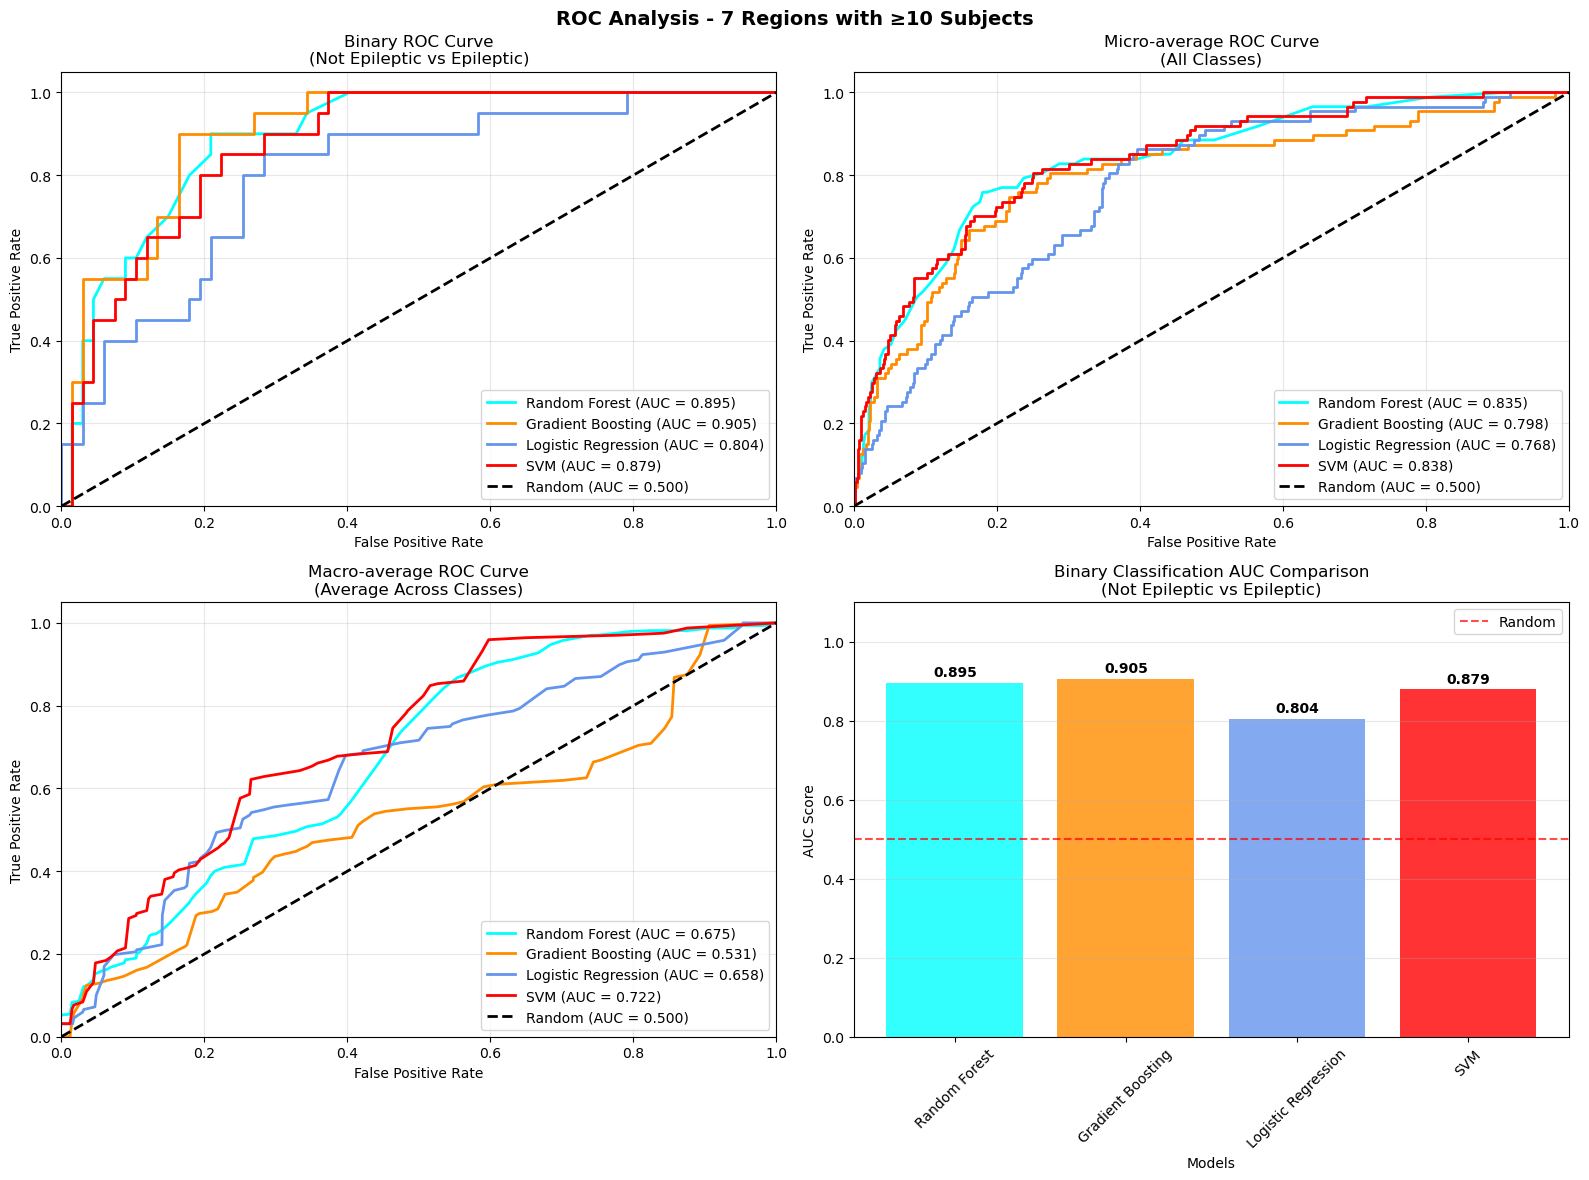


AUC SCORES SUMMARY
                 Model  Binary AUC  Micro AUC  Macro AUC
0        Random Forest       0.895      0.835      0.675
1    Gradient Boosting       0.905      0.798      0.531
2  Logistic Regression       0.804      0.768      0.658
3                  SVM       0.879      0.838      0.722

Best Binary AUC: Gradient Boosting (0.905)
Best Micro AUC: SVM (0.838)
Best Macro AUC: SVM (0.722)

Generating detailed ROC analysis for top 5 classes...


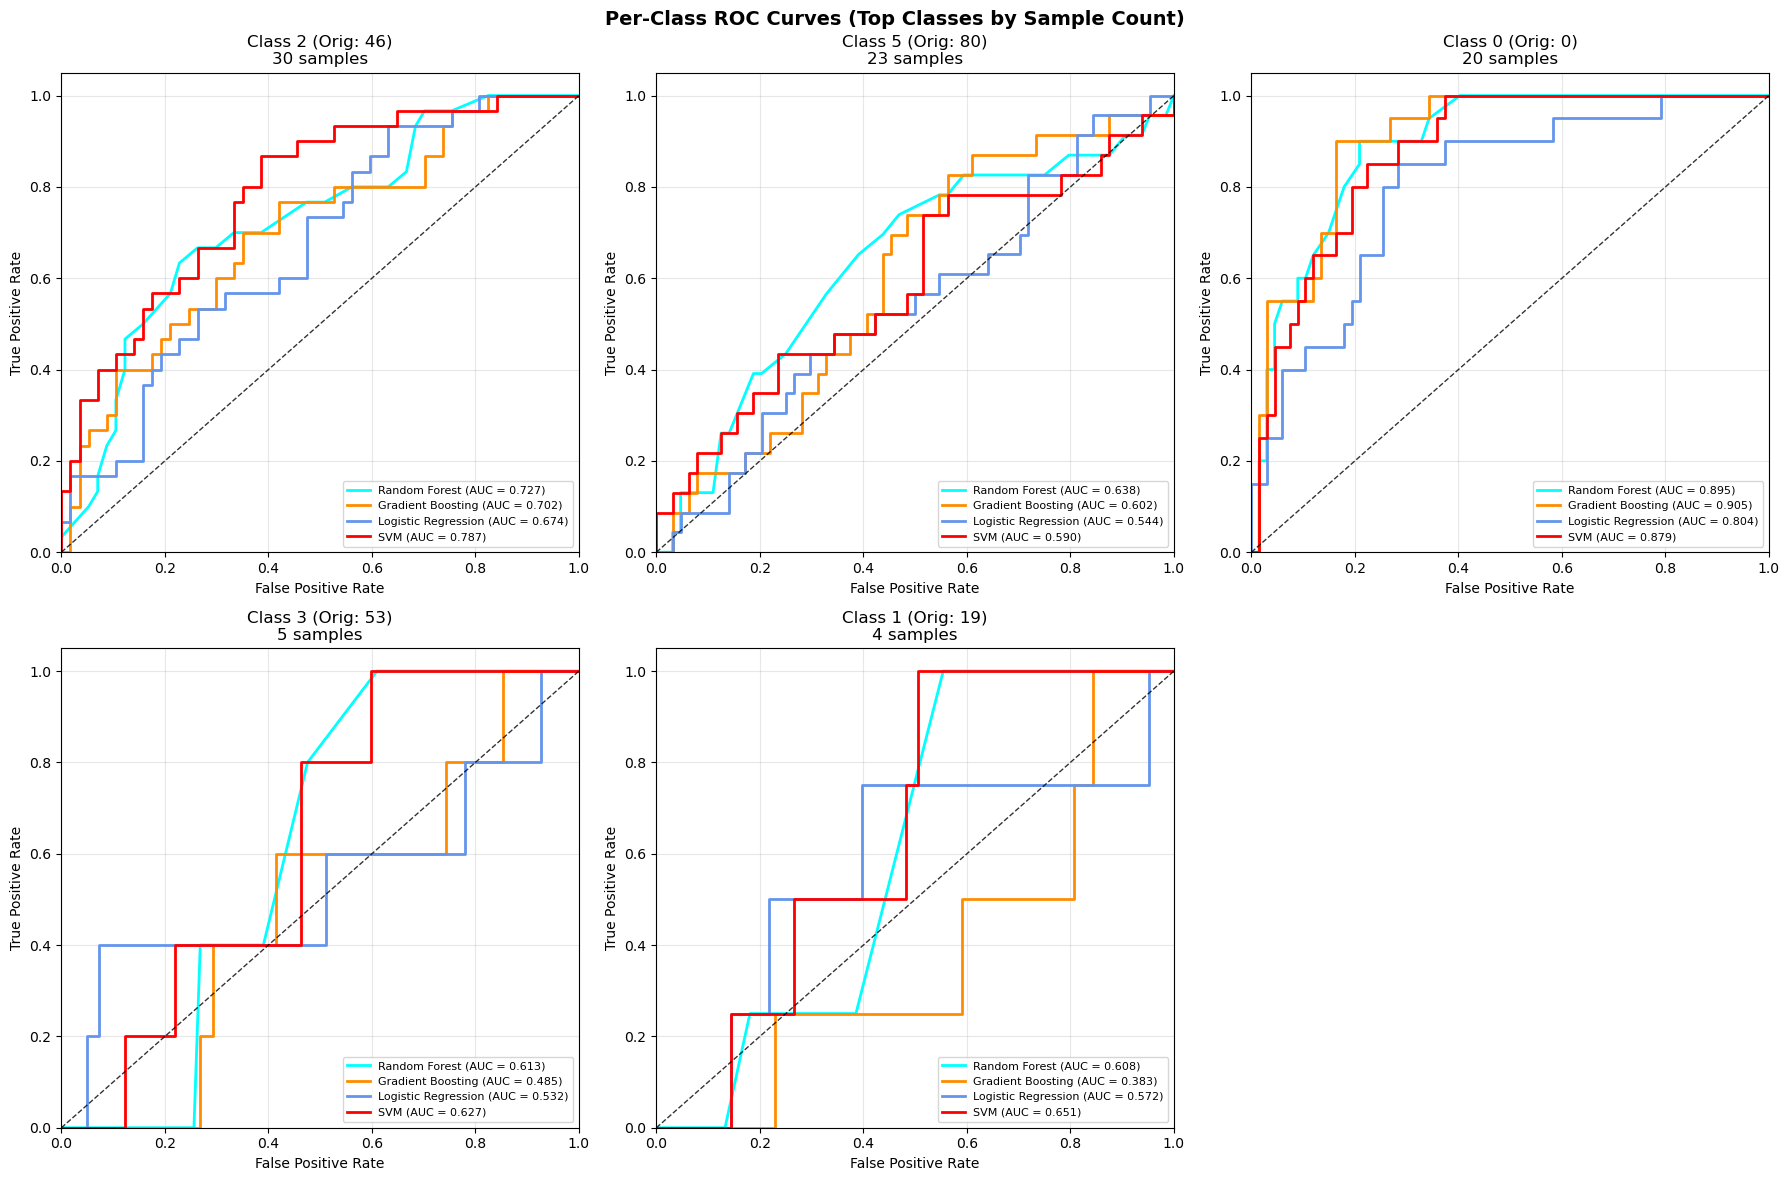

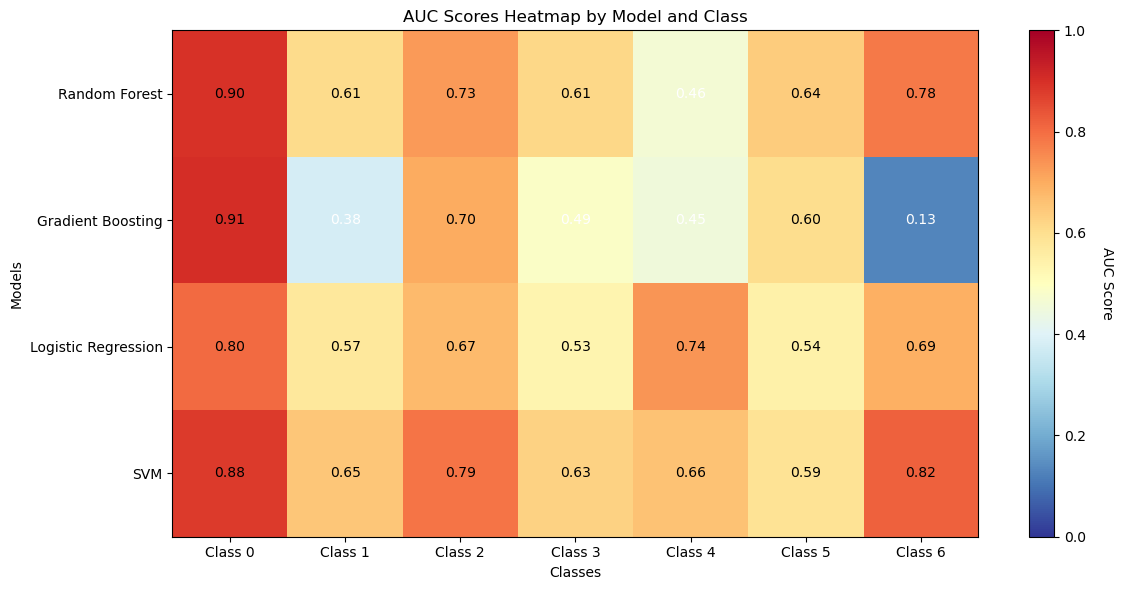

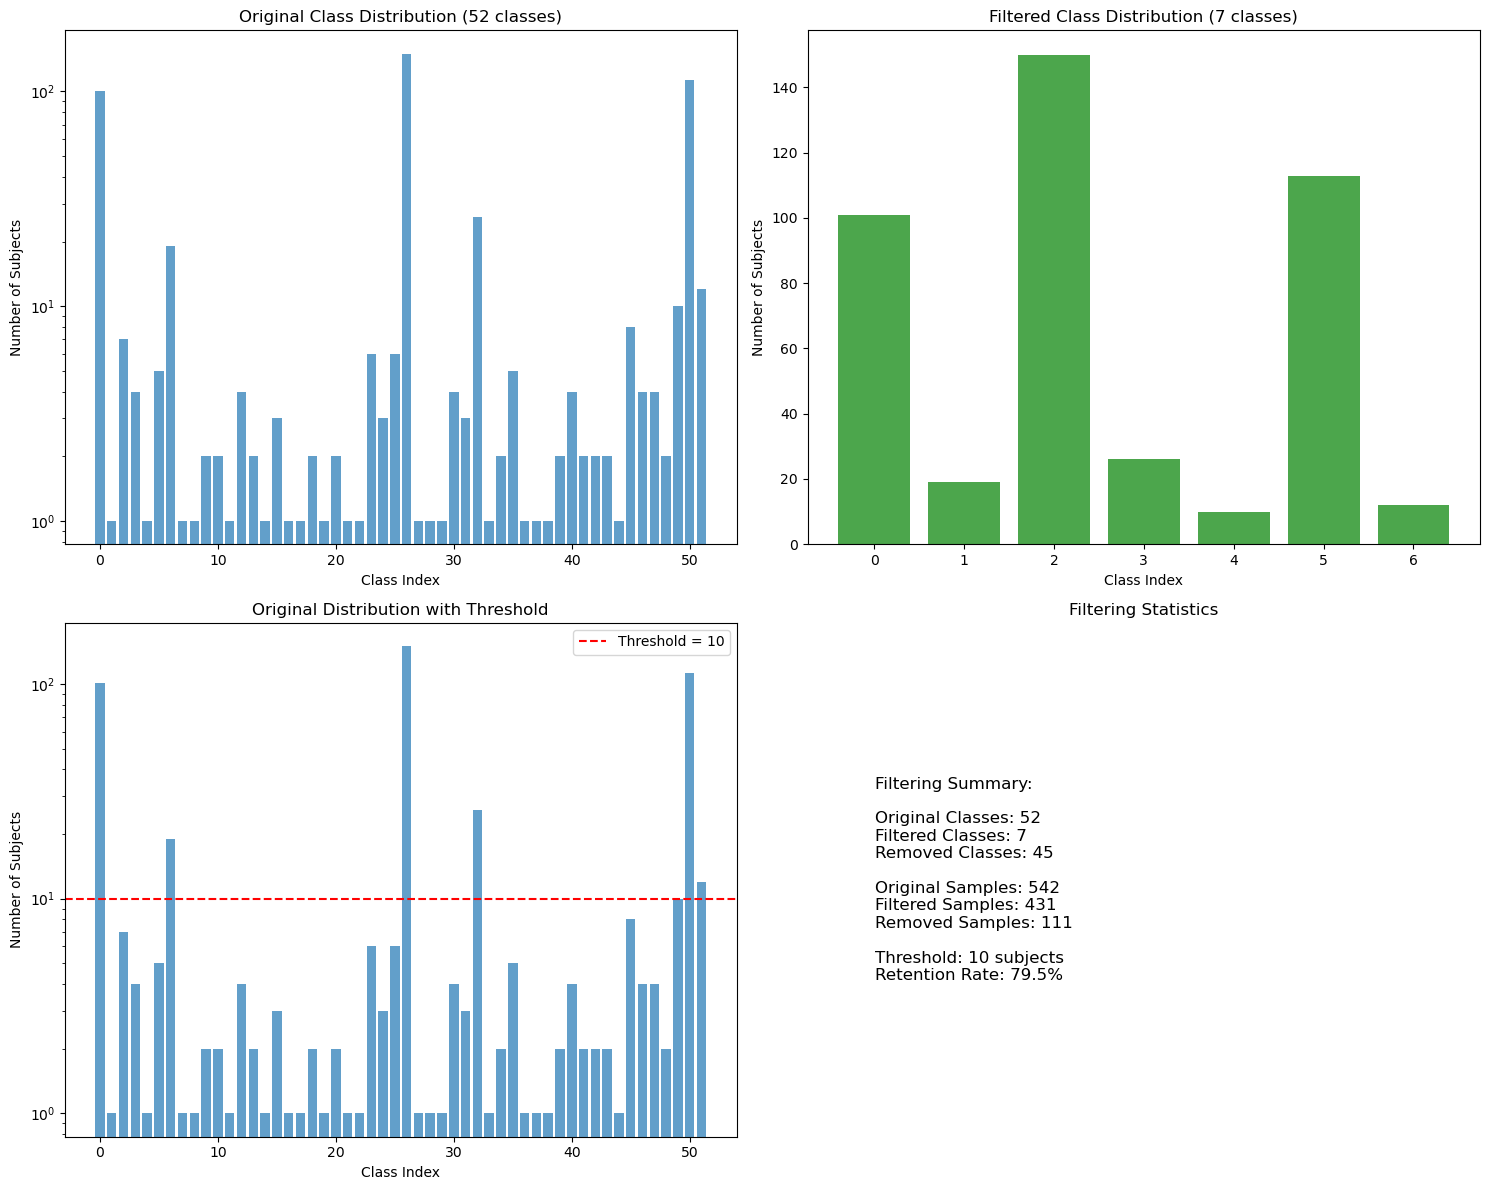


Final Results:
Best performing model: Random Forest
Performance on 7 regions with ≥10 subjects
Balanced Test Accuracy: 0.244
Binary AUC Score: 0.895

Testing threshold: 5 subjects
Using 'Epileptic_Status' as target variable

Original class distribution:
Total classes: 52
Class 0 (not epileptic): 101 subjects
Epileptic regions (1-83): 441 subjects

Regions with >= 5 subjects: 13
Regions with < 5 subjects: 39
Insufficient regions: [3, 13, 15, 20, 21, 22, 24, 25, 28, 30, 31, 32, 33, 34, 35, 38, 40, 41, 42, 44]...

Filtering results:
Original dataset: 542 samples, 52 classes
Filtered dataset: 468 samples, 13 classes
Removed samples: 74 (13.7%)

Final processed data:
Features shape: (468, 593)
Target distribution:
Epileptic_Status
0     101
1       7
2       5
3      19
4       6
5       6
6     150
7      26
8       5
9       8
10     10
11    113
12     12
Name: count, dtype: int64
Minimum samples per class: 5
Selected 50 features out of 593
Minimum class count: 5

Training models on fil

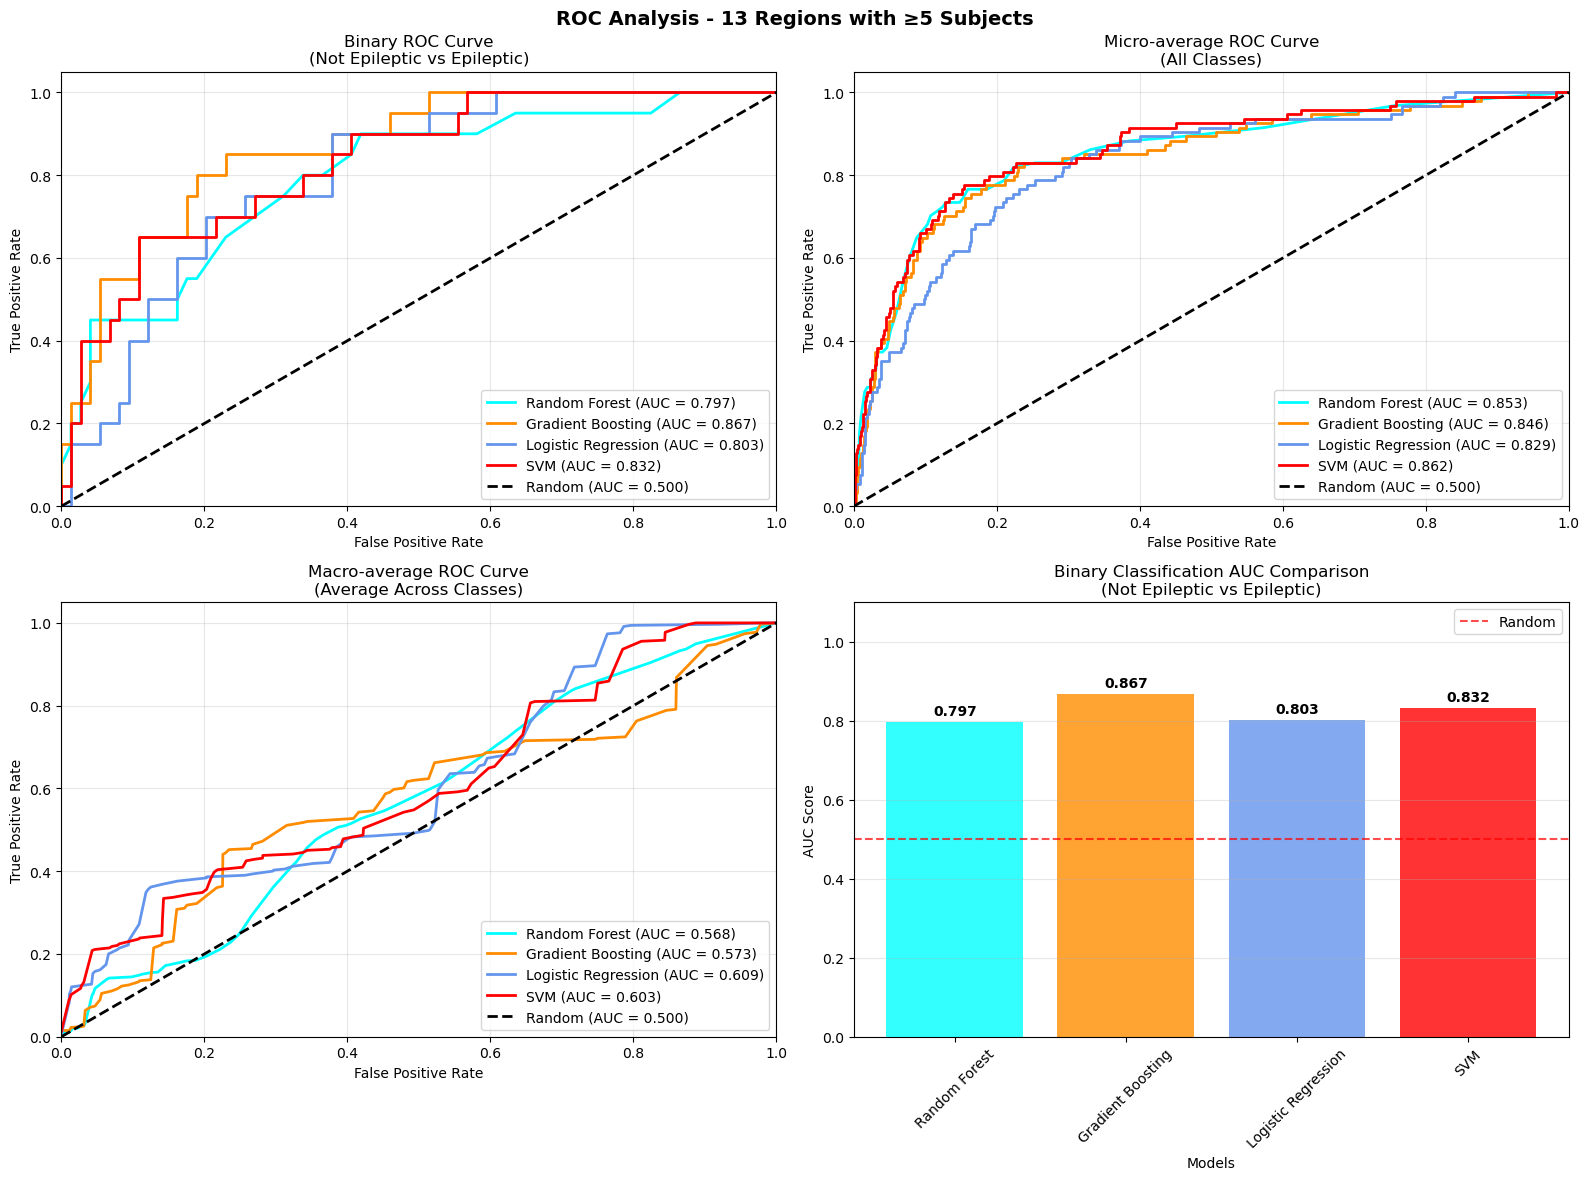


AUC SCORES SUMMARY
                 Model  Binary AUC  Micro AUC  Macro AUC
0        Random Forest       0.797      0.853      0.568
1    Gradient Boosting       0.867      0.846      0.573
2  Logistic Regression       0.803      0.829      0.609
3                  SVM       0.832      0.862      0.603

Best Binary AUC: Gradient Boosting (0.867)
Best Micro AUC: SVM (0.862)
Best Macro AUC: Logistic Regression (0.609)

Generating detailed ROC analysis for top 5 classes...


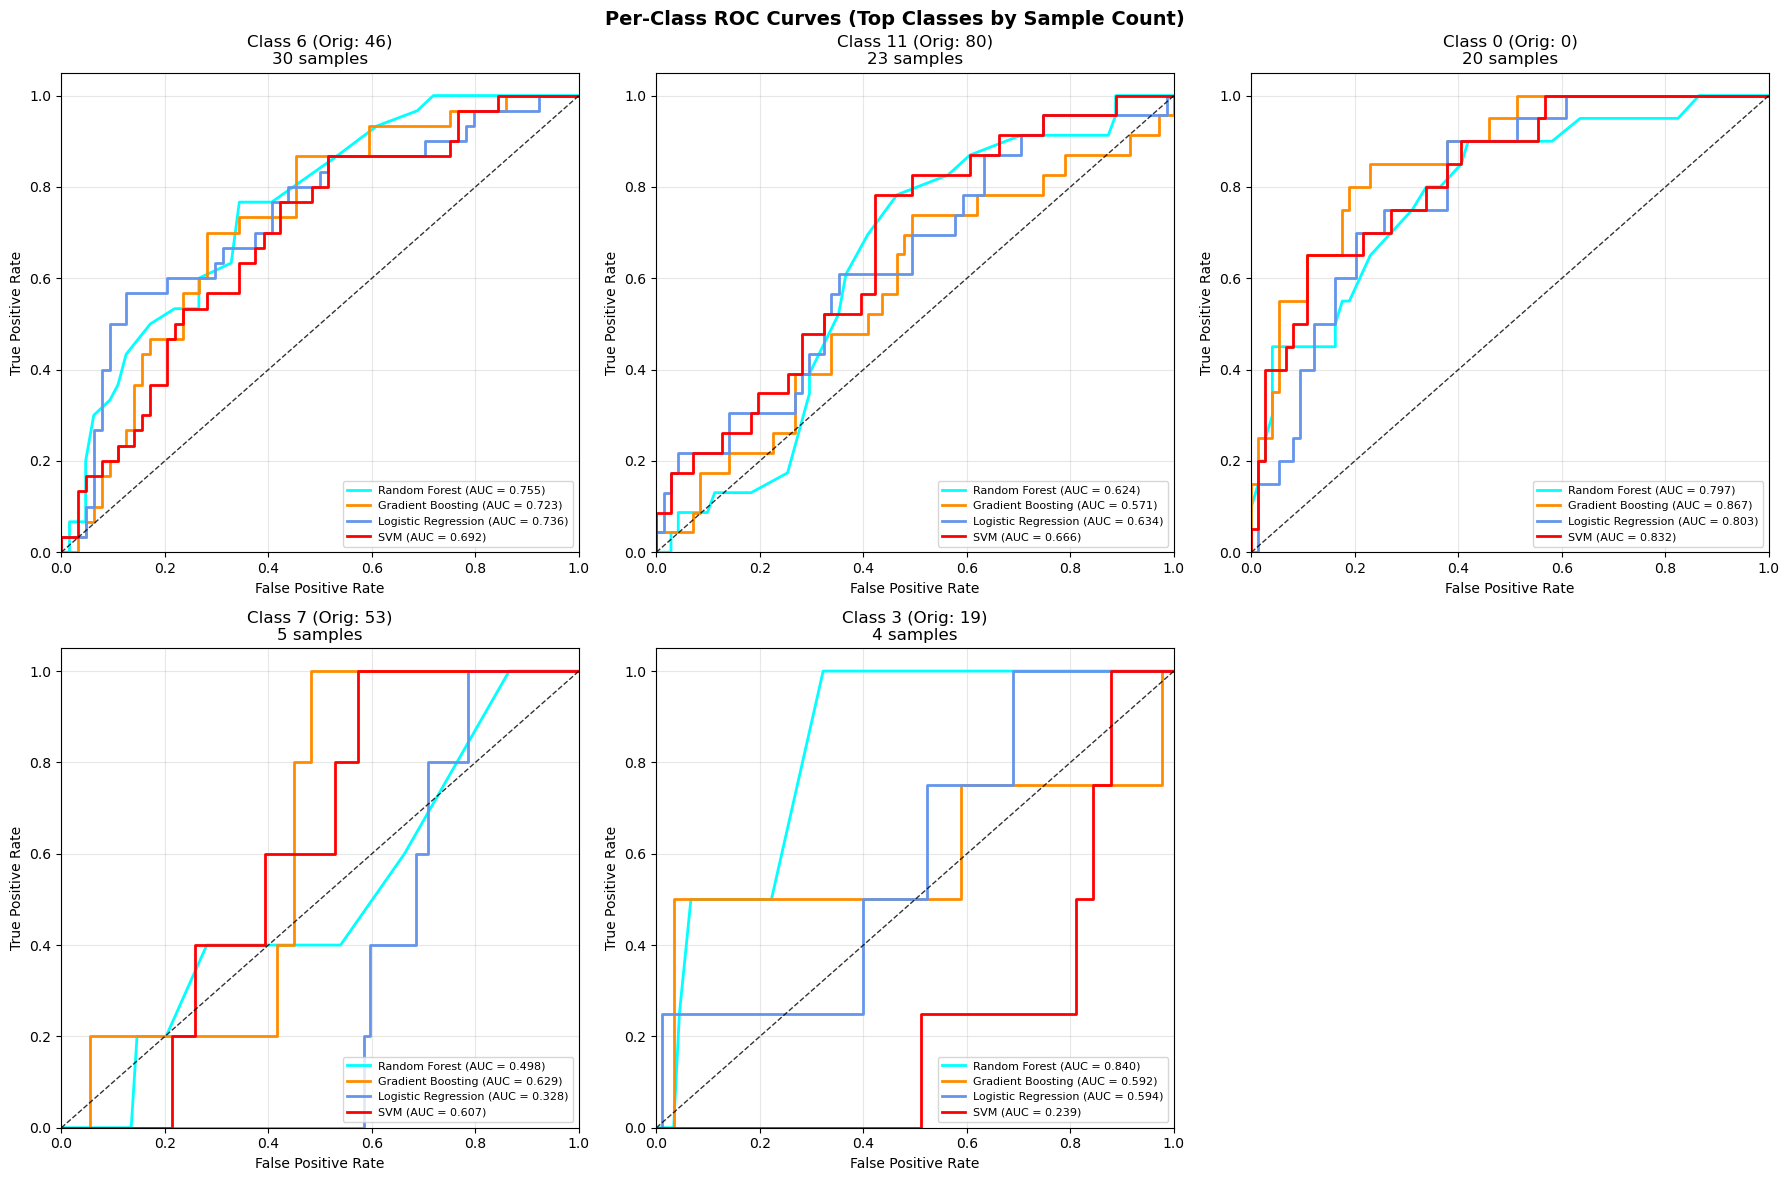

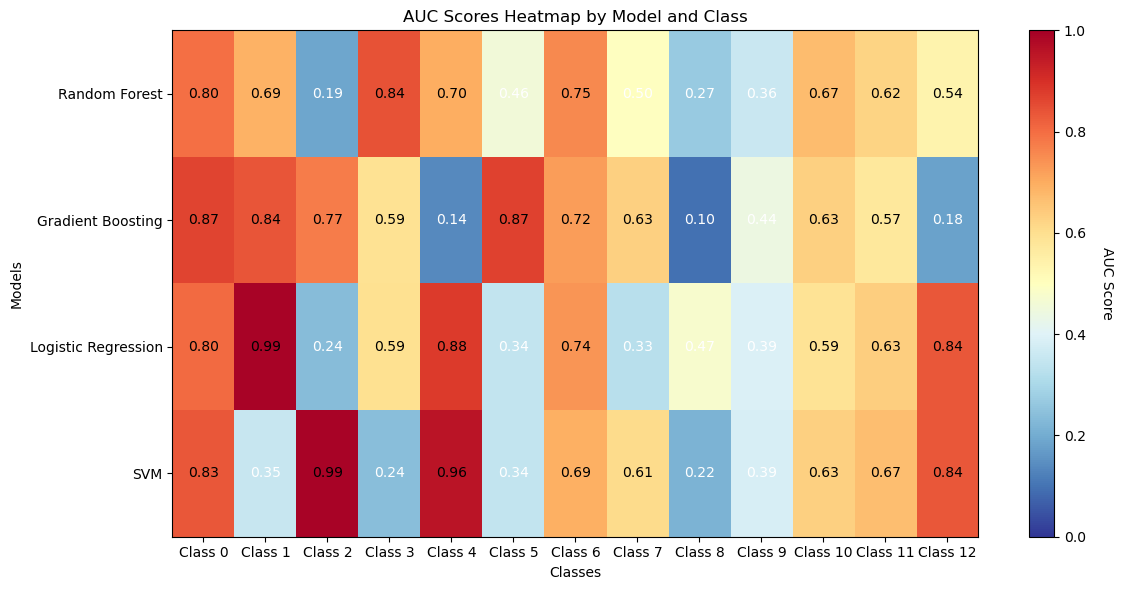

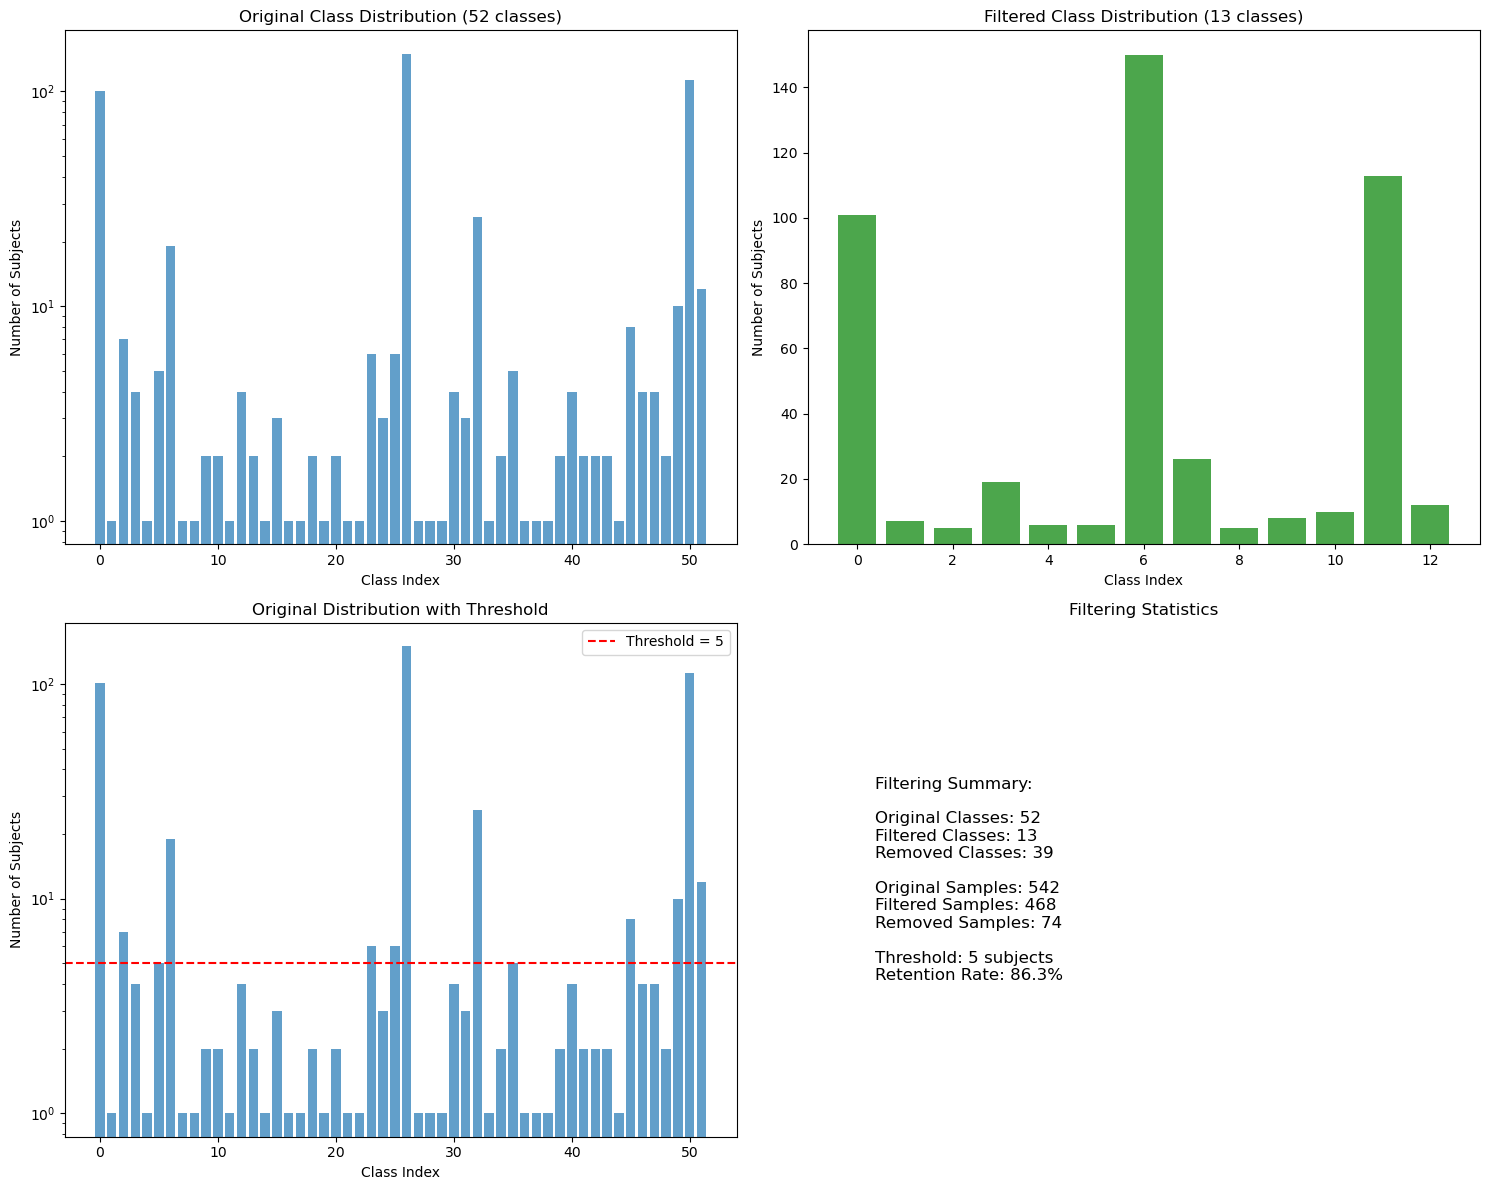


Final Results:
Best performing model: Logistic Regression
Performance on 13 regions with ≥5 subjects
Balanced Test Accuracy: 0.131
Binary AUC Score: 0.803

Testing threshold: 10 subjects
Using 'Epileptic_Status' as target variable

Original class distribution:
Total classes: 52
Class 0 (not epileptic): 101 subjects
Epileptic regions (1-83): 441 subjects

Regions with >= 10 subjects: 7
Regions with < 10 subjects: 45
Insufficient regions: [3, 6, 13, 15, 17, 20, 21, 22, 24, 25, 28, 30, 31, 32, 33, 34, 35, 38, 40, 41]...

Filtering results:
Original dataset: 542 samples, 52 classes
Filtered dataset: 431 samples, 7 classes
Removed samples: 111 (20.5%)

Final processed data:
Features shape: (431, 593)
Target distribution:
Epileptic_Status
0    101
1     19
2    150
3     26
4     10
5    113
6     12
Name: count, dtype: int64
Minimum samples per class: 10
Selected 50 features out of 593
Minimum class count: 10

Training models on filtered data...

Training Random Forest...
CV Balanced Accur

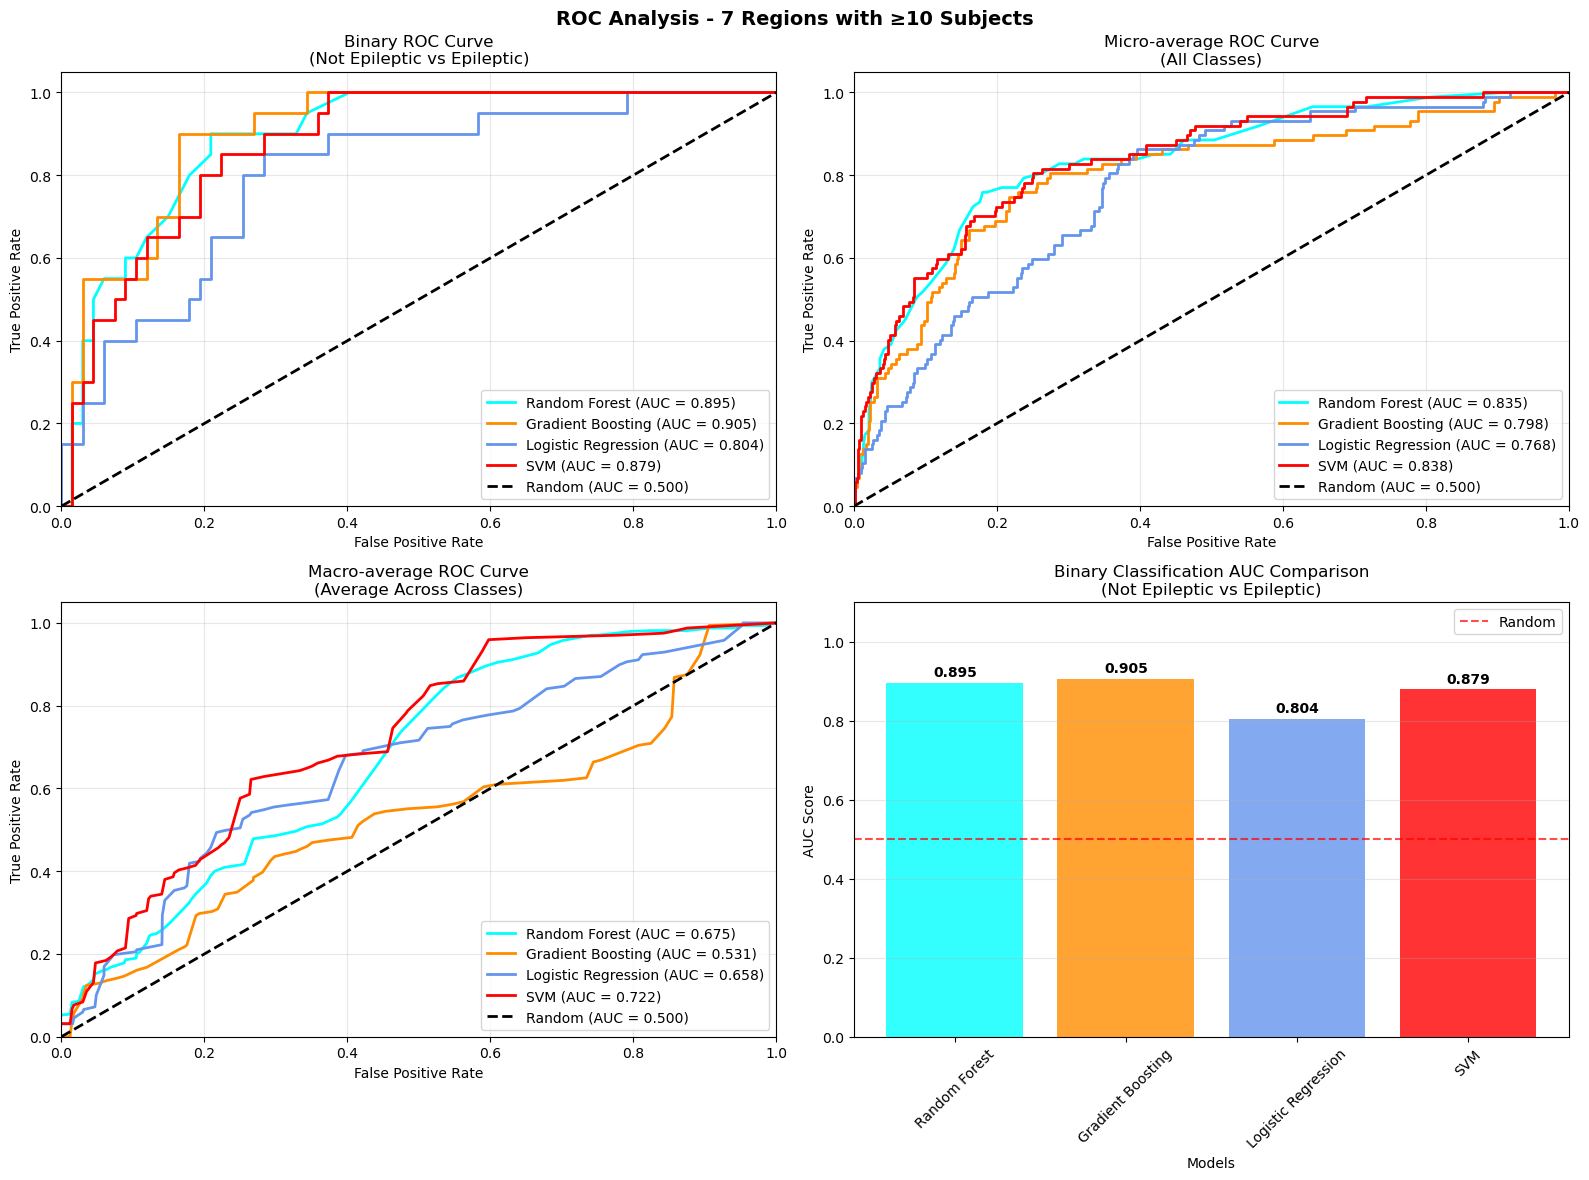


AUC SCORES SUMMARY
                 Model  Binary AUC  Micro AUC  Macro AUC
0        Random Forest       0.895      0.835      0.675
1    Gradient Boosting       0.905      0.798      0.531
2  Logistic Regression       0.804      0.768      0.658
3                  SVM       0.879      0.838      0.722

Best Binary AUC: Gradient Boosting (0.905)
Best Micro AUC: SVM (0.838)
Best Macro AUC: SVM (0.722)

Generating detailed ROC analysis for top 5 classes...


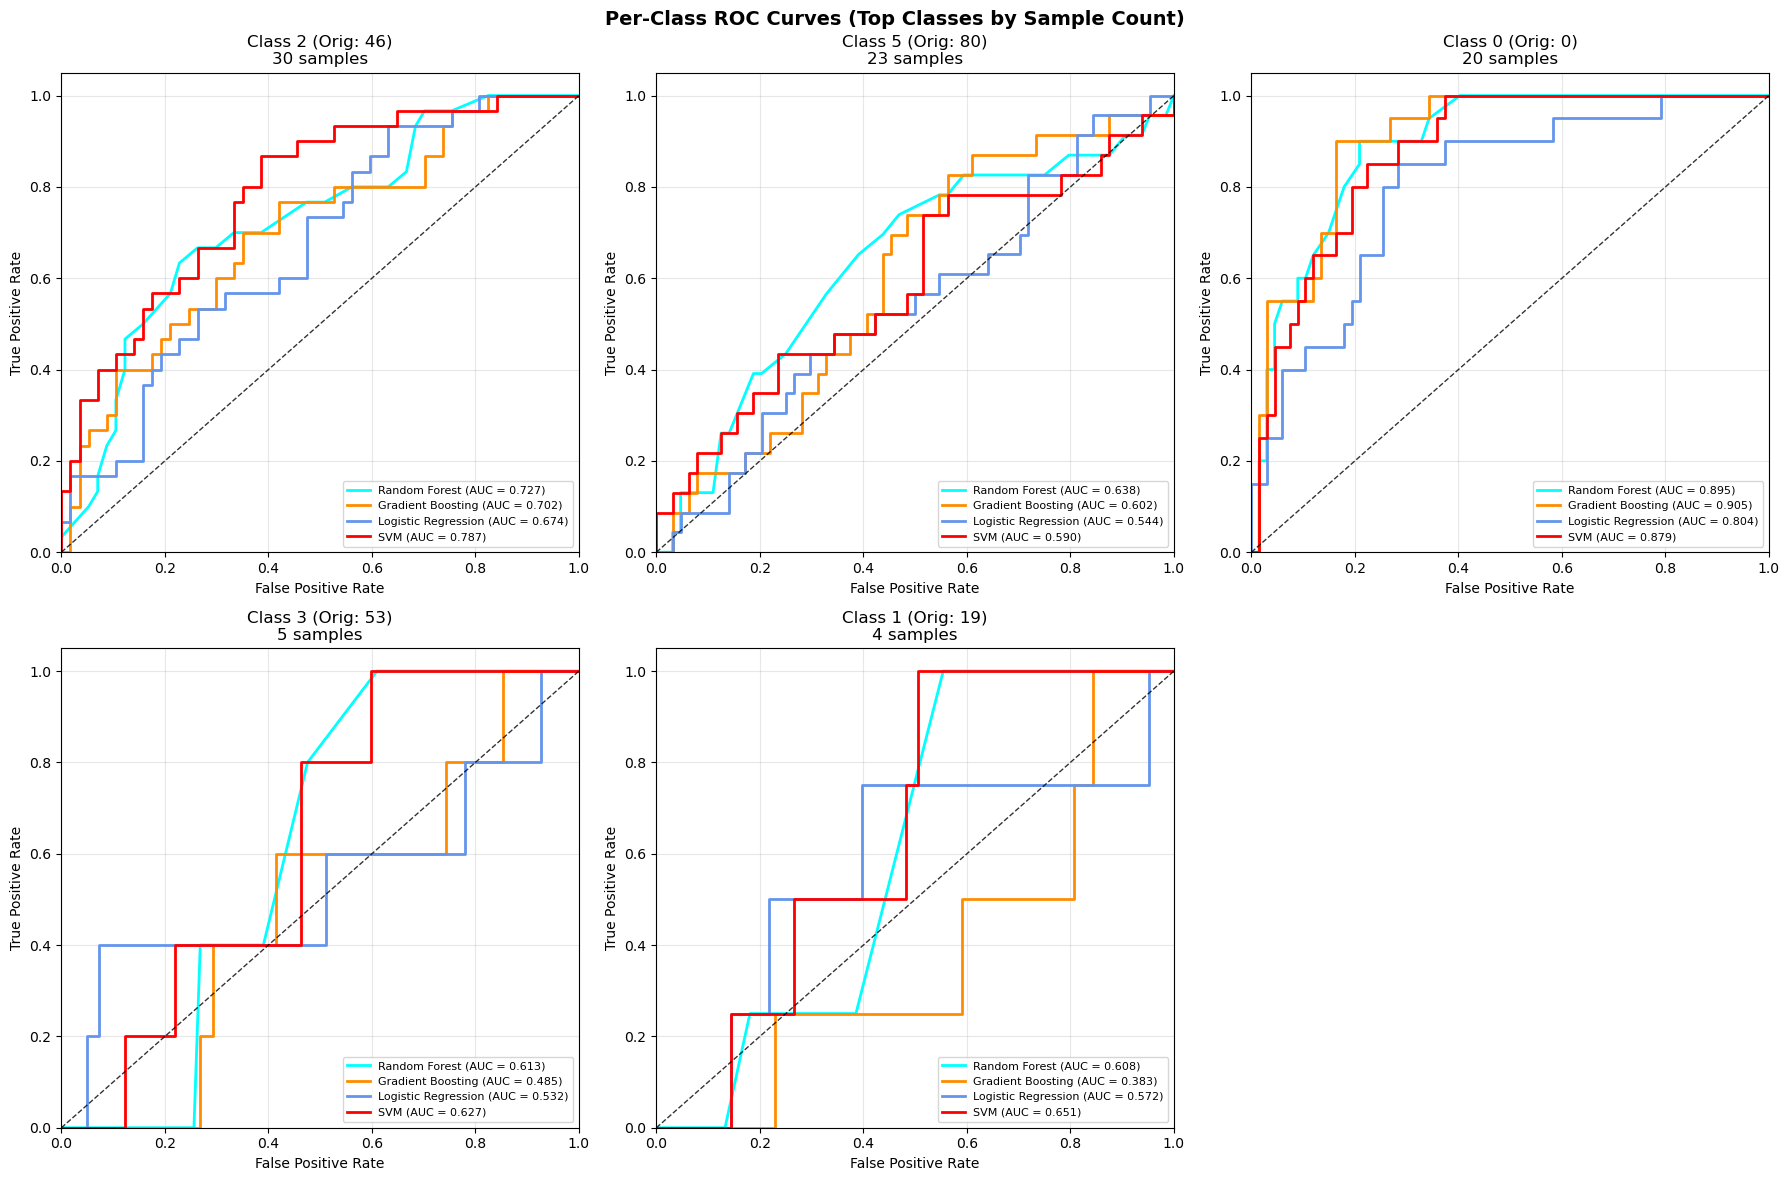

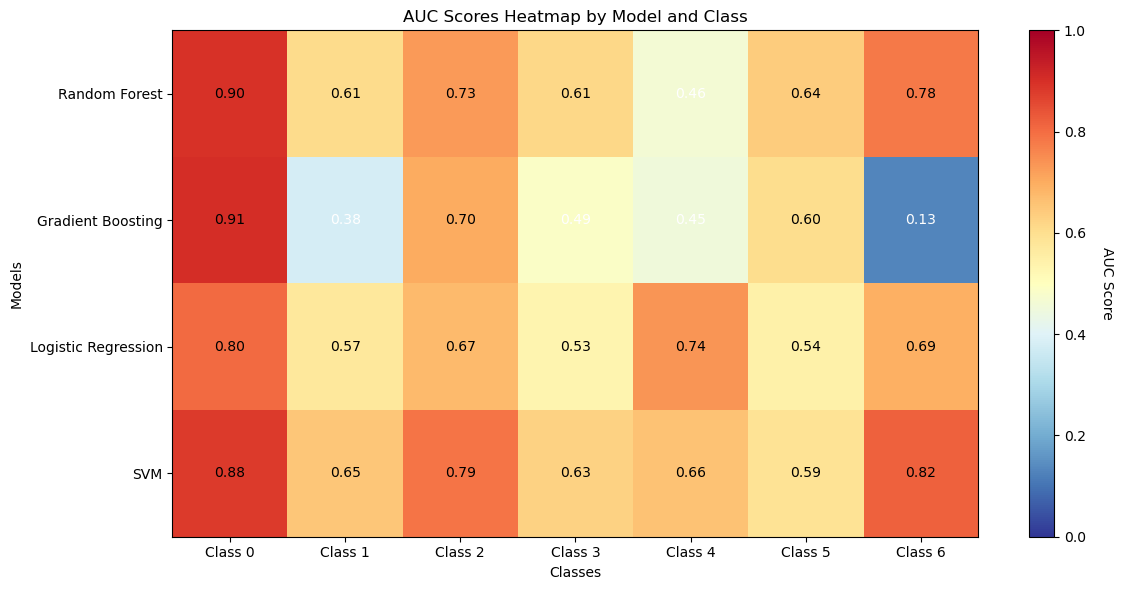

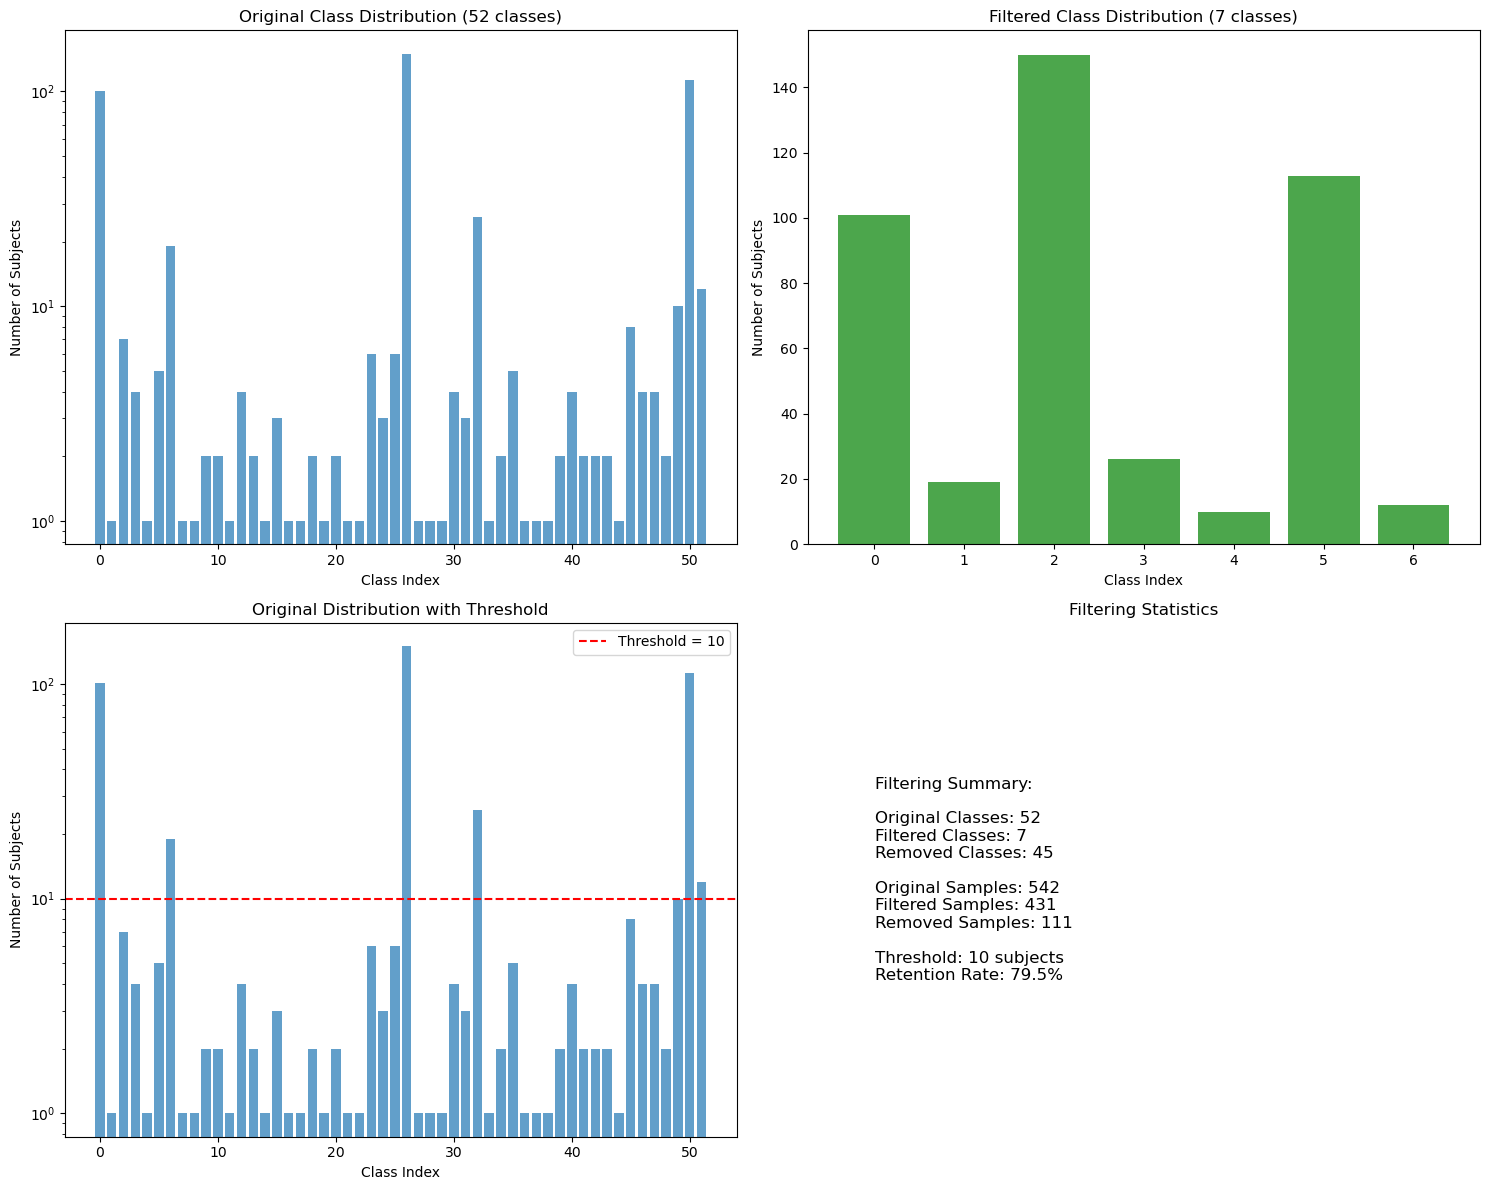


Final Results:
Best performing model: Random Forest
Performance on 7 regions with ≥10 subjects
Balanced Test Accuracy: 0.244
Binary AUC Score: 0.895

Testing threshold: 15 subjects
Using 'Epileptic_Status' as target variable

Original class distribution:
Total classes: 52
Class 0 (not epileptic): 101 subjects
Epileptic regions (1-83): 441 subjects

Regions with >= 15 subjects: 5
Regions with < 15 subjects: 47
Insufficient regions: [3, 6, 13, 15, 17, 20, 21, 22, 24, 25, 28, 30, 31, 32, 33, 34, 35, 38, 40, 41]...

Filtering results:
Original dataset: 542 samples, 52 classes
Filtered dataset: 409 samples, 5 classes
Removed samples: 133 (24.5%)

Final processed data:
Features shape: (409, 593)
Target distribution:
Epileptic_Status
0    101
1     19
2    150
3     26
4    113
Name: count, dtype: int64
Minimum samples per class: 19
Selected 50 features out of 593
Minimum class count: 19

Training models on filtered data...

Training Random Forest...
CV Balanced Accuracy: 0.318 (+/- 0.065)
T

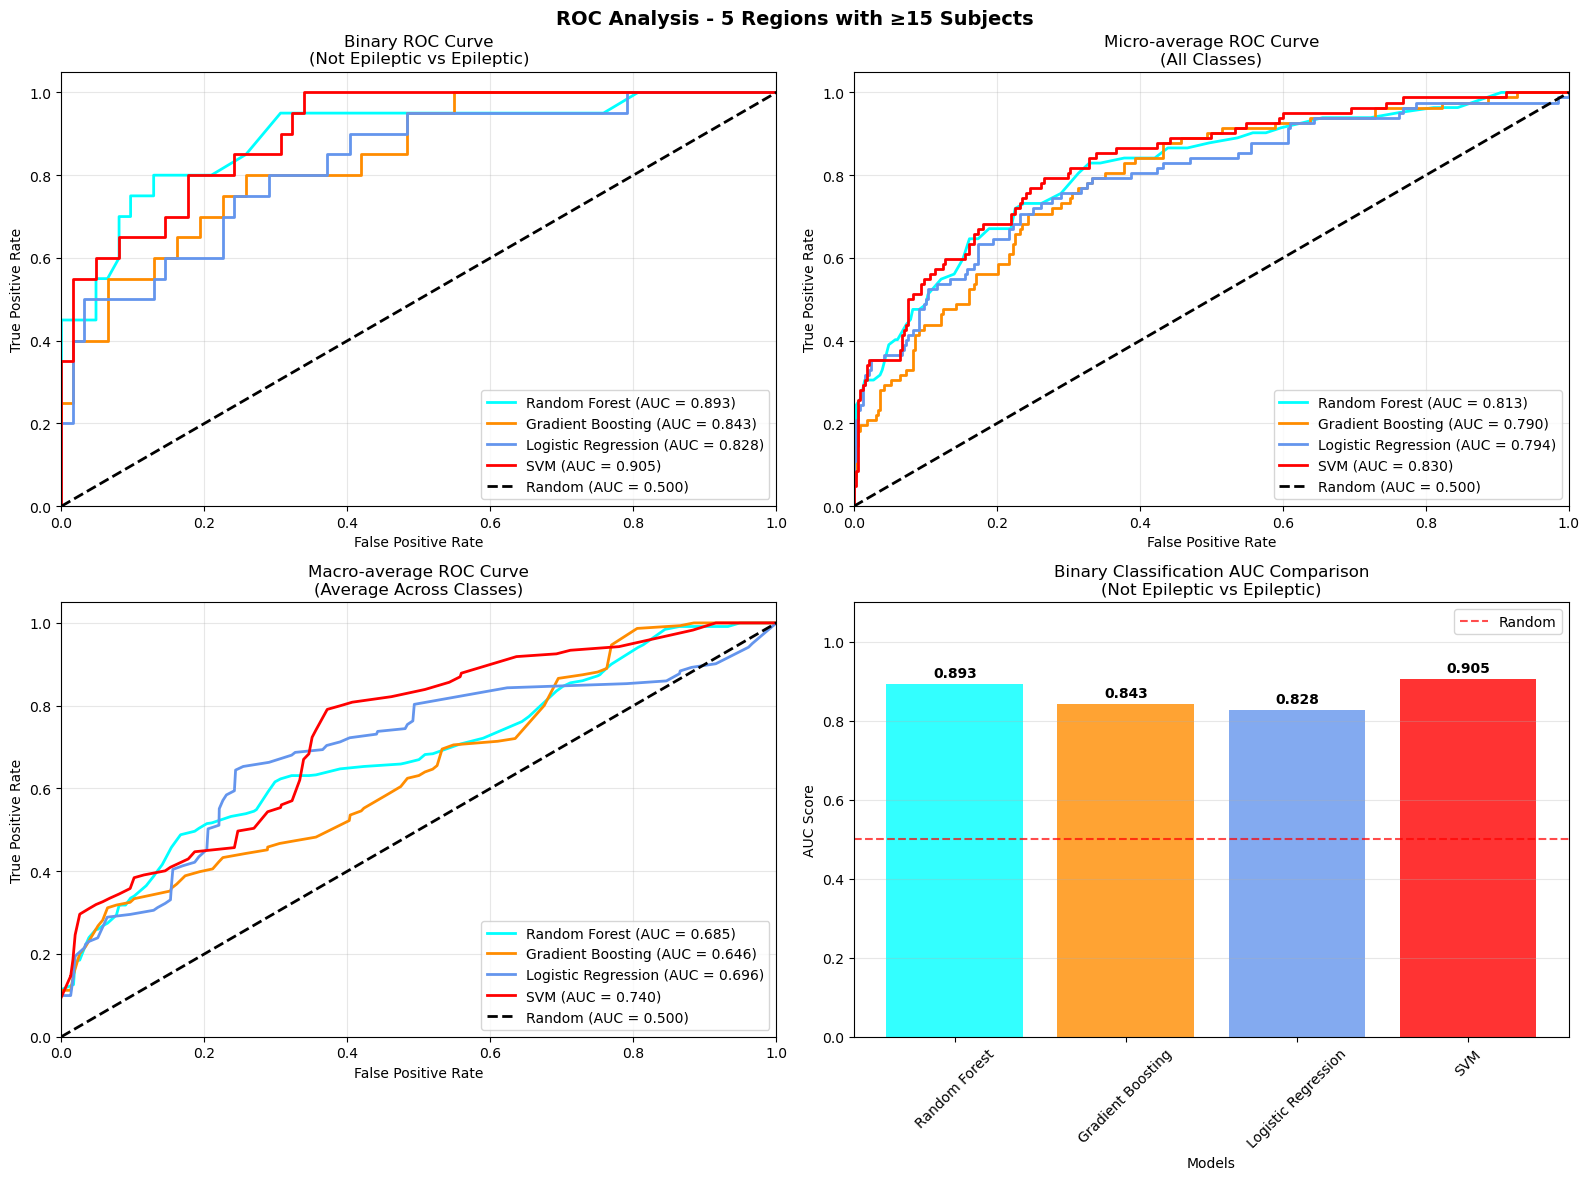


AUC SCORES SUMMARY
                 Model  Binary AUC  Micro AUC  Macro AUC
0        Random Forest       0.893      0.813      0.685
1    Gradient Boosting       0.843      0.790      0.646
2  Logistic Regression       0.828      0.794      0.696
3                  SVM       0.905      0.830      0.740

Best Binary AUC: SVM (0.905)
Best Micro AUC: SVM (0.830)
Best Macro AUC: SVM (0.740)

Generating detailed ROC analysis for top 5 classes...


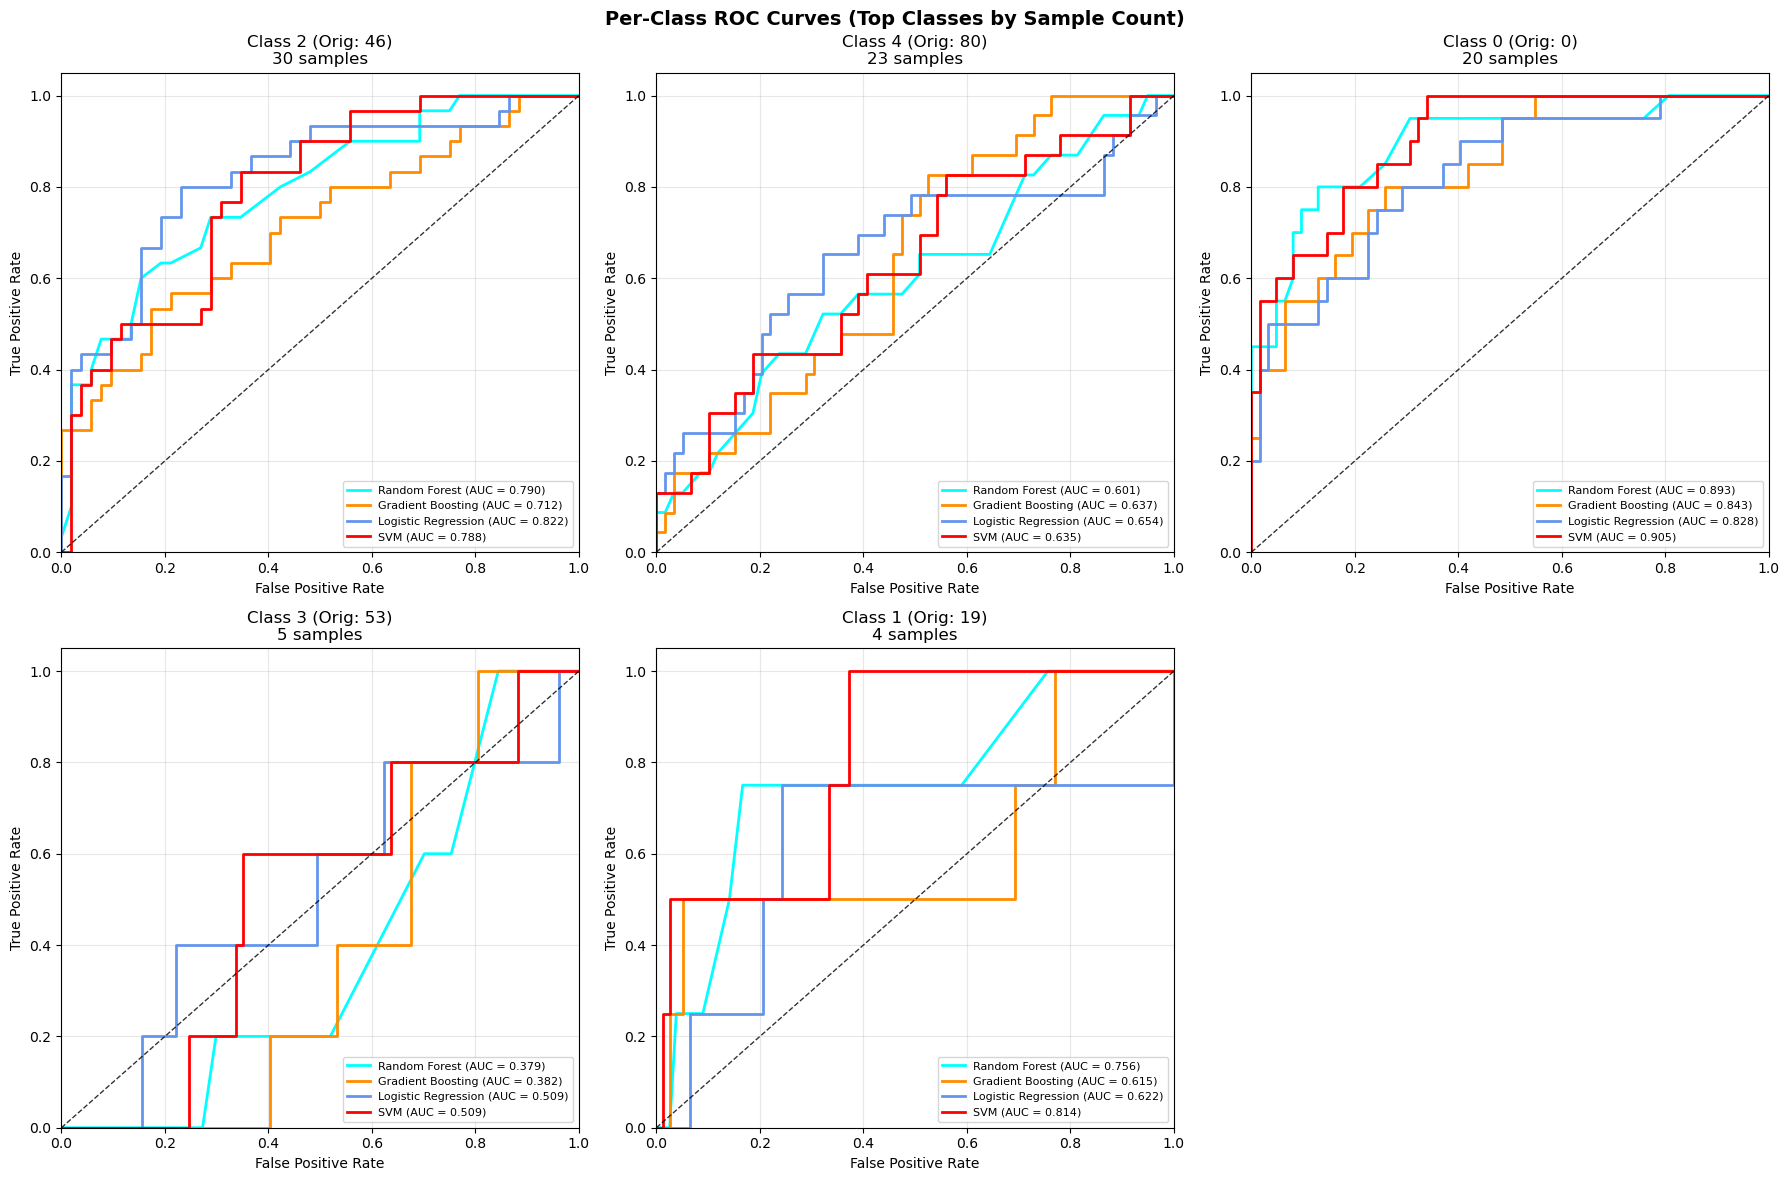

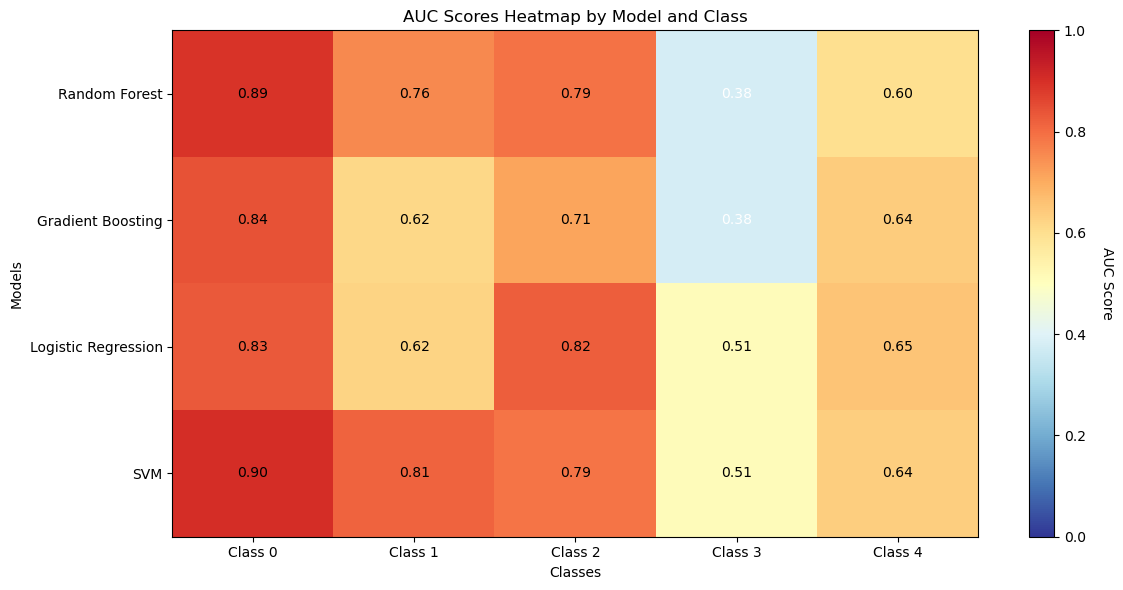

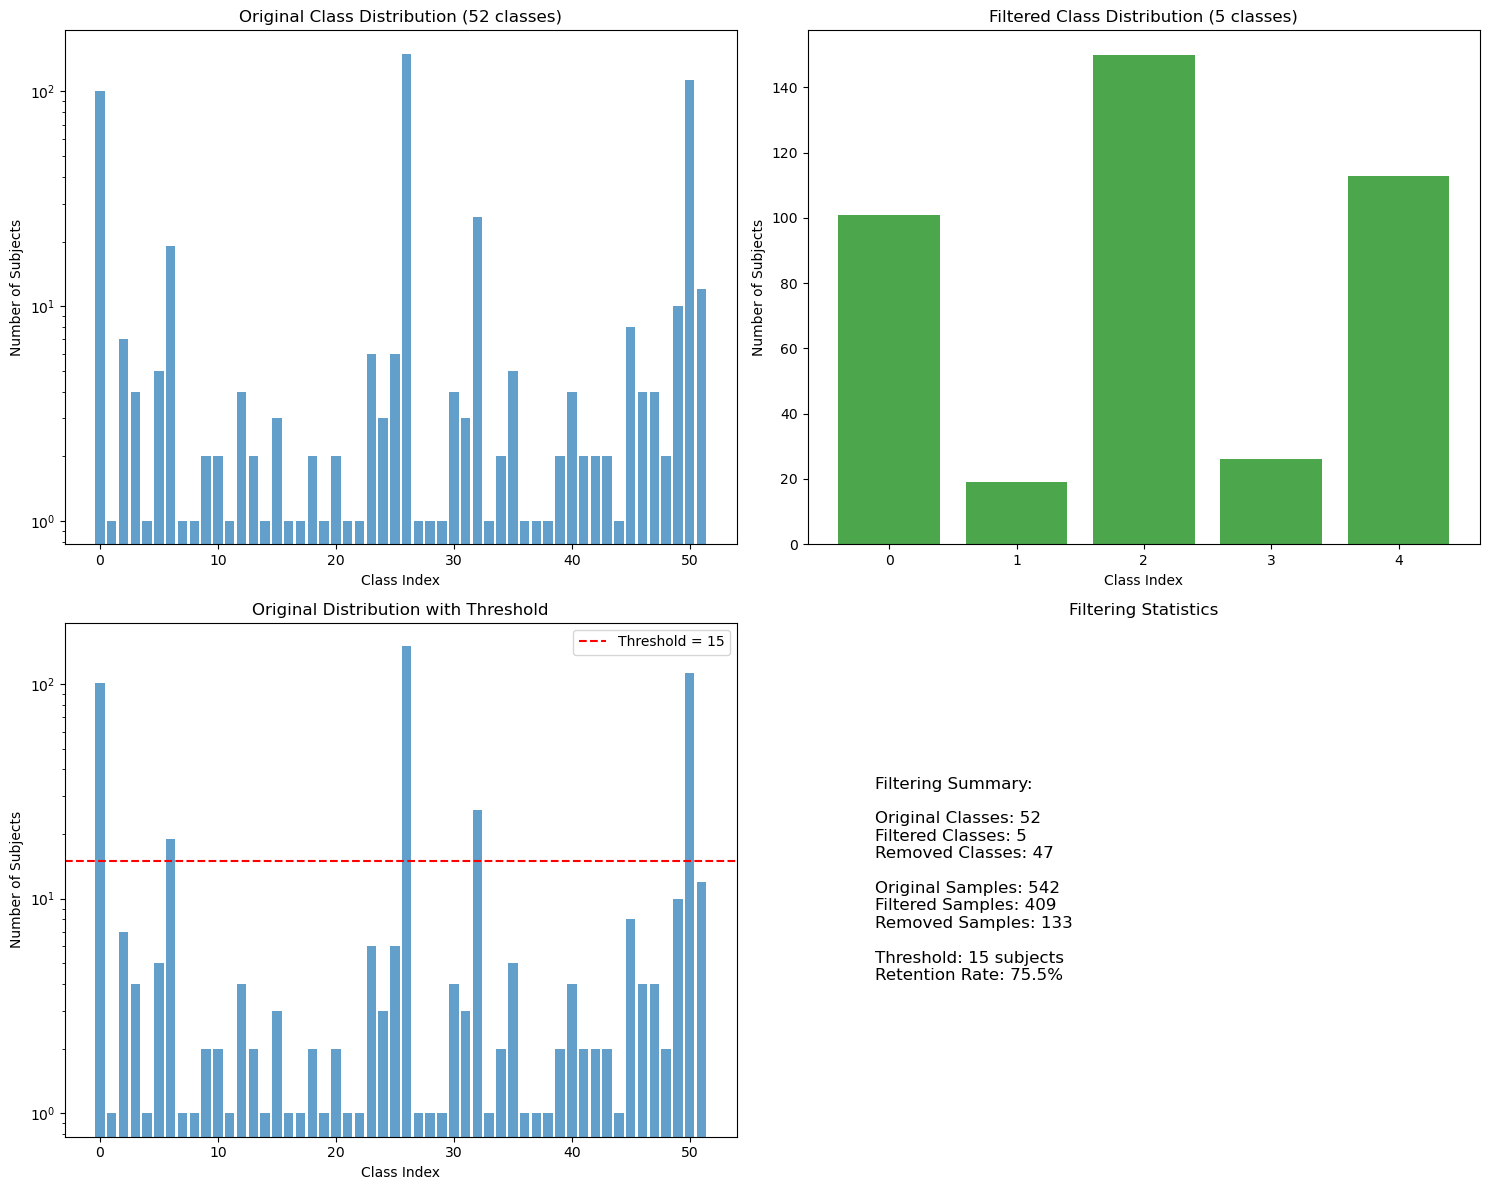


Final Results:
Best performing model: Logistic Regression
Performance on 5 regions with ≥15 subjects
Balanced Test Accuracy: 0.371
Binary AUC Score: 0.828

Threshold Comparison Summary:
   threshold  classes_retained  samples_retained  retention_rate
0          5                13               468            86.3
1         10                 7               431            79.5
2         15                 5               409            75.5


In [109]:
df = pd.read_csv(r'.\lh_updated.csv')
df = df.drop('Subject', axis=1)

def filter_regions_by_subject_count(df, min_subjects=10):
  
    target_candidates = [col for col in df.columns if 'epilep' in col.lower() or 'target' in col.lower() or 'label' in col.lower()]
    
    if not target_candidates:
        print("No obvious target column found. Assuming last column is target.")
        target_col = df.columns[-1]
    else:
        target_col = target_candidates[0]
    
    print(f"Using '{target_col}' as target variable")
    
   
    class_counts = df[target_col].value_counts().sort_index()
    print(f"\nOriginal class distribution:")
    print(f"Total classes: {len(class_counts)}")
    print(f"Class 0 (not epileptic): {class_counts.get(0, 0)} subjects")
    print(f"Epileptic regions (1-83): {class_counts[class_counts.index > 0].sum()} subjects")
    
    
    sufficient_regions = class_counts[class_counts >= min_subjects].index.tolist()
    insufficient_regions = class_counts[class_counts < min_subjects].index.tolist()
    
    print(f"\nRegions with >= {min_subjects} subjects: {len(sufficient_regions)}")
    print(f"Regions with < {min_subjects} subjects: {len(insufficient_regions)}")
    
    if len(insufficient_regions) > 0:
        print(f"Insufficient regions: {insufficient_regions[:20]}{'...' if len(insufficient_regions) > 20 else ''}")
    
   
    filtered_df = df[df[target_col].isin(sufficient_regions)].copy()
    
   
    label_mapping = {old_label: new_label for new_label, old_label in enumerate(sufficient_regions)}
    filtered_df[target_col] = filtered_df[target_col].map(label_mapping)
    
    
    region_stats = {
        'original_classes': len(class_counts),
        'filtered_classes': len(sufficient_regions),
        'original_samples': len(df),
        'filtered_samples': len(filtered_df),
        'removed_samples': len(df) - len(filtered_df),
        'min_subjects_threshold': min_subjects,
        'sufficient_regions': sufficient_regions,
        'insufficient_regions': insufficient_regions,
        'label_mapping': label_mapping
    }
    
    print(f"\nFiltering results:")
    print(f"Original dataset: {region_stats['original_samples']} samples, {region_stats['original_classes']} classes")
    print(f"Filtered dataset: {region_stats['filtered_samples']} samples, {region_stats['filtered_classes']} classes")
    print(f"Removed samples: {region_stats['removed_samples']} ({region_stats['removed_samples']/region_stats['original_samples']*100:.1f}%)")
    
    return filtered_df, region_stats

def preprocess_data_with_threshold(df, min_subjects=10):
    
    
    filtered_df, region_stats = filter_regions_by_subject_count(df, min_subjects)
    
    
    target_candidates = [col for col in filtered_df.columns if 'epilep' in col.lower() or 'target' in col.lower() or 'label' in col.lower()]
    
    if not target_candidates:
        target_col = filtered_df.columns[-1]
    else:
        target_col = target_candidates[0]
    
   
    X = filtered_df.drop(columns=[target_col])
    y = filtered_df[target_col]
    
   
    if y.dtype == 'object':
        le = LabelEncoder()
        y = le.fit_transform(y)
        print(f"Target classes: {le.classes_}")
    
   
    numeric_cols = X.select_dtypes(include=[np.number]).columns
    X = X[numeric_cols]
    
    print(f"\nFinal processed data:")
    print(f"Features shape: {X.shape}")
    print(f"Target distribution:")
    value_counts = pd.Series(y).value_counts().sort_index()
    print(value_counts)
    
 
    min_samples_per_class = value_counts.min()
    print(f"Minimum samples per class: {min_samples_per_class}")
    
    if min_samples_per_class < min_subjects:
        print(f"Warning: Some classes still have fewer than {min_subjects} subjects after filtering!")
    
    return X, y, target_col, region_stats

def feature_engineering(X, y):
    
    
    X = X.fillna(X.median())
    
    
    constant_features = X.columns[X.var() == 0]
    if len(constant_features) > 0:
        print(f"Removing {len(constant_features)} constant features")
        X = X.drop(columns=constant_features)
    
    
    selector = SelectKBest(score_func=f_classif, k=min(50, X.shape[1]))
    X_selected = selector.fit_transform(X, y)
    selected_features = X.columns[selector.get_support()]
    
    print(f"Selected {len(selected_features)} features out of {X.shape[1]}")
    
    return pd.DataFrame(X_selected, columns=selected_features), selected_features

def train_models(X, y):
    
    class_counts = pd.Series(y).value_counts()
    min_class_count = class_counts.min()
    
    print(f"Minimum class count: {min_class_count}")
    
    if min_class_count < 2:
        print(f"Warning: Some classes have only {min_class_count} sample(s). Using random split instead of stratified split.")
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    
    models = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, multi_class='ovr', class_weight='balanced'),
        'SVM': SVC(random_state=42, probability=True, class_weight='balanced')
    }
    
    results = {}
    
    print("\nTraining models on filtered data...")
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        
        if name in ['Logistic Regression', 'SVM']:
            X_train_model = X_train_scaled
            X_test_model = X_test_scaled
        else:
            X_train_model = X_train
            X_test_model = X_test
        
       
        model.fit(X_train_model, y_train)
        
        
        y_pred = model.predict(X_test_model)
        y_pred_proba = model.predict_proba(X_test_model)
        
        
        cv_scores = cross_val_score(model, X_train_model, y_train, cv=3, scoring='balanced_accuracy')
        test_accuracy = accuracy_score(y_test, y_pred)
        balanced_test_accuracy = balanced_accuracy_score(y_test, y_pred)
        
        results[name] = {
            'model': model,
            'cv_balanced_accuracy': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'test_accuracy': test_accuracy,
            'balanced_test_accuracy': balanced_test_accuracy,
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba,
            'scaler': scaler if name in ['Logistic Regression', 'SVM'] else None
        }
        
        print(f"CV Balanced Accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
        print(f"Test Accuracy: {test_accuracy:.3f}")
        print(f"Balanced Test Accuracy: {balanced_test_accuracy:.3f}")
    
    return results, X_test, y_test

def evaluate_models(results, X_test, y_test, region_stats):
    """Evaluate and visualize model performance"""
    print("\n" + "="*50)
    print("MODEL COMPARISON (FILTERED DATA)")
    print("="*50)
    
    
    comparison_df = pd.DataFrame({
        'Model': list(results.keys()),
        'CV Balanced Accuracy': [results[model]['cv_balanced_accuracy'] for model in results],
        'Test Accuracy': [results[model]['test_accuracy'] for model in results],
        'Balanced Test Accuracy': [results[model]['balanced_test_accuracy'] for model in results]
    })
    
    print(comparison_df.round(3))
    
   
    best_model_name = comparison_df.loc[comparison_df['Balanced Test Accuracy'].idxmax(), 'Model']
    best_model_results = results[best_model_name]
    
    print(f"\nBest model: {best_model_name}")
    print(f"Best Balanced Test Accuracy: {best_model_results['balanced_test_accuracy']:.3f}")
    print(f"Regular Test Accuracy: {best_model_results['test_accuracy']:.3f}")
    
   
    print(f"\nDetailed evaluation for {best_model_name}:")
    print("\nClassification Report:")
    print(classification_report(y_test, best_model_results['y_pred']))
    
    
    
    return best_model_name, best_model_results, comparison_df

def plot_roc_curves(results, X_test, y_test, region_stats):
   
    n_classes = len(np.unique(y_test))
   
    
    
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple'])
    
    
    if n_classes == 2:
        
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        ax_binary = axes[0]
        ax_comparison = axes[1]
    else:
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        ax_binary = axes[0, 0]
        ax_micro = axes[0, 1]
        ax_macro = axes[1, 0]
        ax_comparison = axes[1, 1]
    
    
    model_auc_scores = {}
    
   
   
    y_test_binary = (y_test == 0).astype(int)
    
    for (model_name, model_results), color in zip(results.items(), colors):
        
        y_pred_proba = model_results['y_pred_proba']
        
      
        if y_pred_proba.shape[1] > 2:
            
            y_score_binary = y_pred_proba[:, 0] 
        else:
           
            y_score_binary = y_pred_proba[:, 1]  
            y_test_binary = 1 - y_test_binary  
        
        
        fpr, tpr, _ = roc_curve(y_test_binary, y_score_binary)
        roc_auc = auc(fpr, tpr)
        
    
        model_auc_scores[model_name] = {'binary_auc': roc_auc}
        
       
        ax_binary.plot(fpr, tpr, color=color, lw=2,
                      label=f'{model_name} (AUC = {roc_auc:.3f})')
    
  
    ax_binary.plot([0, 1], [0, 1], 'k--', lw=2, label='Random (AUC = 0.500)')
    ax_binary.set_xlim([0.0, 1.0])
    ax_binary.set_ylim([0.0, 1.05])
    ax_binary.set_xlabel('False Positive Rate')
    ax_binary.set_ylabel('True Positive Rate')
    ax_binary.set_title('Binary ROC Curve\n(Not Epileptic vs Epileptic)')
    ax_binary.legend(loc="lower right")
    ax_binary.grid(True, alpha=0.3)
    
   
    if n_classes > 2:
     
        
        
        y_test_binarized = label_binarize(y_test, classes=range(n_classes))
        
        for model_name, model_results in results.items():
            y_pred_proba = model_results['y_pred_proba']
            
            
            fpr_micro, tpr_micro, _ = roc_curve(y_test_binarized.ravel(), y_pred_proba.ravel())
            roc_auc_micro = auc(fpr_micro, tpr_micro)
            
            
            fpr_macro = dict()
            tpr_macro = dict()
            roc_auc_macro = dict()
            
            for i in range(n_classes):
                if i < y_pred_proba.shape[1]:  
                    fpr_macro[i], tpr_macro[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
                    roc_auc_macro[i] = auc(fpr_macro[i], tpr_macro[i])
            
          
            all_fpr = np.unique(np.concatenate([fpr_macro[i] for i in roc_auc_macro.keys()]))
            mean_tpr = np.zeros_like(all_fpr)
            for i in roc_auc_macro.keys():
                mean_tpr += np.interp(all_fpr, fpr_macro[i], tpr_macro[i])
            mean_tpr /= len(roc_auc_macro)
            roc_auc_macro_avg = auc(all_fpr, mean_tpr)
            
            model_auc_scores[model_name].update({
                'micro_auc': roc_auc_micro,
                'macro_auc': roc_auc_macro_avg
            })
        
  
        colors_micro = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red'])
        for (model_name, model_results), color in zip(results.items(), colors_micro):
            y_pred_proba = model_results['y_pred_proba']
            fpr_micro, tpr_micro, _ = roc_curve(y_test_binarized.ravel(), y_pred_proba.ravel())
            roc_auc_micro = auc(fpr_micro, tpr_micro)
            
            ax_micro.plot(fpr_micro, tpr_micro, color=color, lw=2,
                         label=f'{model_name} (AUC = {roc_auc_micro:.3f})')
        
        ax_micro.plot([0, 1], [0, 1], 'k--', lw=2, label='Random (AUC = 0.500)')
        ax_micro.set_xlim([0.0, 1.0])
        ax_micro.set_ylim([0.0, 1.05])
        ax_micro.set_xlabel('False Positive Rate')
        ax_micro.set_ylabel('True Positive Rate')
        ax_micro.set_title('Micro-average ROC Curve\n(All Classes)')
        ax_micro.legend(loc="lower right")
        ax_micro.grid(True, alpha=0.3)

        colors_macro = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red'])
        for (model_name, model_results), color in zip(results.items(), colors_macro):
            auc_score = model_auc_scores[model_name]['macro_auc']
            
            
            y_pred_proba = model_results['y_pred_proba']
            fpr_macro = dict()
            tpr_macro = dict()
            
            for i in range(min(n_classes, y_pred_proba.shape[1])):
                fpr_macro[i], tpr_macro[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
            
            all_fpr = np.unique(np.concatenate([fpr_macro[i] for i in fpr_macro.keys()]))
            mean_tpr = np.zeros_like(all_fpr)
            for i in fpr_macro.keys():
                mean_tpr += np.interp(all_fpr, fpr_macro[i], tpr_macro[i])
            mean_tpr /= len(fpr_macro)
            
            ax_macro.plot(all_fpr, mean_tpr, color=color, lw=2,
                         label=f'{model_name} (AUC = {auc_score:.3f})')
        
        ax_macro.plot([0, 1], [0, 1], 'k--', lw=2, label='Random (AUC = 0.500)')
        ax_macro.set_xlim([0.0, 1.0])
        ax_macro.set_ylim([0.0, 1.05])
        ax_macro.set_xlabel('False Positive Rate')
        ax_macro.set_ylabel('True Positive Rate')
        ax_macro.set_title('Macro-average ROC Curve\n(Average Across Classes)')
        ax_macro.legend(loc="lower right")
        ax_macro.grid(True, alpha=0.3)
    

    models = list(model_auc_scores.keys())
    binary_aucs = [model_auc_scores[model]['binary_auc'] for model in models]
    
    x_pos = np.arange(len(models))
    bars = ax_comparison.bar(x_pos, binary_aucs, alpha=0.8, color=['aqua', 'darkorange', 'cornflowerblue', 'red'][:len(models)])

    for i, (bar, auc_val) in enumerate(zip(bars, binary_aucs)):
        height = bar.get_height()
        ax_comparison.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                          f'{auc_val:.3f}', ha='center', va='bottom', fontweight='bold')
    
    ax_comparison.set_xlabel('Models')
    ax_comparison.set_ylabel('AUC Score')
    ax_comparison.set_title('Binary Classification AUC Comparison\n(Not Epileptic vs Epileptic)')
    ax_comparison.set_xticks(x_pos)
    ax_comparison.set_xticklabels(models, rotation=45)
    ax_comparison.set_ylim([0, 1.1])
    ax_comparison.grid(True, alpha=0.3, axis='y')
    
   
    ax_comparison.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='Random')
    ax_comparison.legend()
    
    plt.suptitle(f'ROC Analysis - {region_stats["filtered_classes"]} Regions with ≥{region_stats["min_subjects_threshold"]} Subjects', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
  
    print("\n" + "="*50)
    print("AUC SCORES SUMMARY")
    print("="*50)
    
    auc_summary_df = pd.DataFrame({
        'Model': models,
        'Binary AUC': binary_aucs
    })
    
    if n_classes > 2:
        micro_aucs = [model_auc_scores[model]['micro_auc'] for model in models]
        macro_aucs = [model_auc_scores[model]['macro_auc'] for model in models]
        auc_summary_df['Micro AUC'] = micro_aucs
        auc_summary_df['Macro AUC'] = macro_aucs
    
    print(auc_summary_df.round(3))
    

    best_binary_model = models[np.argmax(binary_aucs)]
    print(f"\nBest Binary AUC: {best_binary_model} ({max(binary_aucs):.3f})")
    
    if n_classes > 2:
        best_micro_model = models[np.argmax(micro_aucs)]
        best_macro_model = models[np.argmax(macro_aucs)]
        print(f"Best Micro AUC: {best_micro_model} ({max(micro_aucs):.3f})")
        print(f"Best Macro AUC: {best_macro_model} ({max(macro_aucs):.3f})")
    
    return model_auc_scores, auc_summary_df

def plot_detailed_roc_analysis(results, X_test, y_test, region_stats, top_classes=5):
   
    
    n_classes = len(np.unique(y_test))
    
    if n_classes <= 2:
        print("Detailed ROC analysis is for multiclass problems (>2 classes)")
        return
    
    print(f"\nGenerating detailed ROC analysis for top {top_classes} classes...")
    

    class_counts = pd.Series(y_test).value_counts().sort_values(ascending=False)
    top_class_indices = class_counts.head(top_classes).index.tolist()
    

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()

    y_test_binarized = label_binarize(y_test, classes=range(n_classes))

    colors = ['aqua', 'darkorange', 'cornflowerblue', 'red']

    for idx, class_i in enumerate(top_class_indices):
        if idx >= 6: 
            break
            
        ax = axes[idx]
        
        for (model_name, model_results), color in zip(results.items(), colors):
            y_pred_proba = model_results['y_pred_proba']
            
            if class_i < y_pred_proba.shape[1]:
               
                fpr, tpr, _ = roc_curve(y_test_binarized[:, class_i], y_pred_proba[:, class_i])
                roc_auc = auc(fpr, tpr)
                
                ax.plot(fpr, tpr, color=color, lw=2,
                       label=f'{model_name} (AUC = {roc_auc:.3f})')
        
        ax.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.8)
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')

        original_class = region_stats['sufficient_regions'][class_i] if class_i < len(region_stats['sufficient_regions']) else class_i
        sample_count = class_counts[class_i]
        ax.set_title(f'Class {class_i} (Orig: {original_class})\n{sample_count} samples')
        ax.legend(loc="lower right", fontsize=8)
        ax.grid(True, alpha=0.3)
    

    for idx in range(len(top_class_indices), 6):
        axes[idx].set_visible(False)
    
    plt.suptitle('Per-Class ROC Curves (Top Classes by Sample Count)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    

    auc_matrix = []
    model_names = list(results.keys())
    
    for model_name in model_names:
        model_aucs = []
        y_pred_proba = results[model_name]['y_pred_proba']
        
        for class_i in range(min(n_classes, y_pred_proba.shape[1])):
            if class_i < y_test_binarized.shape[1]:
                fpr, tpr, _ = roc_curve(y_test_binarized[:, class_i], y_pred_proba[:, class_i])
                roc_auc = auc(fpr, tpr)
                model_aucs.append(roc_auc)
            else:
                model_aucs.append(0.0)
        
        auc_matrix.append(model_aucs)
    

    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    

    im = ax.imshow(auc_matrix, cmap='RdYlBu_r', aspect='auto', vmin=0, vmax=1)
    

    ax.set_xticks(range(len(auc_matrix[0])))
    ax.set_yticks(range(len(model_names)))
    ax.set_xticklabels([f'Class {i}' for i in range(len(auc_matrix[0]))])
    ax.set_yticklabels(model_names)
    
    
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('AUC Score', rotation=270, labelpad=20)
  
    for i in range(len(model_names)):
        for j in range(len(auc_matrix[0])):
            text = ax.text(j, i, f'{auc_matrix[i][j]:.2f}',
                          ha="center", va="center", color="black" if auc_matrix[i][j] > 0.5 else "white")
    
    ax.set_title('AUC Scores Heatmap by Model and Class')
    ax.set_xlabel('Classes')
    ax.set_ylabel('Models')
    
    plt.tight_layout()
    plt.show()
    
    return auc_matrix

def main(min_subjects=10):
  
   
    

    df_original = pd.read_csv(r'.\lh_updated.csv')
    df_original = df_original.drop('Subject', axis=1)

    target_candidates = [col for col in df_original.columns if 'epilep' in col.lower() or 'target' in col.lower() or 'label' in col.lower()]
    target_col_original = target_candidates[0] if target_candidates else df_original.columns[-1]
    y_original = df_original[target_col_original]

    X, y, target_col, region_stats = preprocess_data_with_threshold(df_original, min_subjects)
    
    if X is not None and len(X) > 0:
       
        X, selected_features = feature_engineering(X, y)
        
       
        results, X_test, y_test = train_models(X, y)
        
        
        best_model_name, best_model_results, comparison_df = evaluate_models(results, X_test, y_test, region_stats)
        
        
        model_auc_scores, auc_summary_df = plot_roc_curves(results, X_test, y_test, region_stats)
        
        
        n_classes = len(np.unique(y))
        
        plot_detailed_roc_analysis(results, X_test, y_test, region_stats, top_classes=5)
        
     
        plot_filtering_results(region_stats, y_original, y)
        
        print(f"\nFinal Results:")
        print(f"Best performing model: {best_model_name}")
        print(f"Performance on {region_stats['filtered_classes']} regions with ≥{min_subjects} subjects")
        print(f"Balanced Test Accuracy: {best_model_results['balanced_test_accuracy']:.3f}")
        print(f"Binary AUC Score: {model_auc_scores[best_model_name]['binary_auc']:.3f}")
        
        return best_model_name, best_model_results, region_stats, model_auc_scores
    else:
        print("No data remaining after filtering. Consider lowering the threshold.")
        return None, None, None

if __name__ == "__main__":
    
    MIN_SUBJECTS_THRESHOLD = 10  
 
    best_model, results, stats, auc_scores = main(min_subjects=MIN_SUBJECTS_THRESHOLD)
    
   
   
    thresholds = [5, 10, 15]
    threshold_results = []
    
    for threshold in thresholds:
        print(f"\nTesting threshold: {threshold} subjects")
        try:
            _, _, stats, _ = main(min_subjects=threshold)
            if stats:
                threshold_results.append({
                    'threshold': threshold,
                    'classes_retained': stats['filtered_classes'],
                    'samples_retained': stats['filtered_samples'],
                    'retention_rate': stats['filtered_samples']/stats['original_samples']*100
                })
        except Exception as e:
            print(f"Error with threshold {threshold}: {e}")
    
    if threshold_results:
        threshold_df = pd.DataFrame(threshold_results)
        print("\nThreshold Comparison Summary:")
        print(threshold_df.round(1))